In [1]:
# visualizes the parcellated results from step 9 (using schaefer 400)

# imports and general helper functions

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker

In [2]:
# general helper functions:
def build_contrast_map_path(base_dir, level, subject, session, task, contrast_name):
    """Build the file path for a contrast map."""
    filename = f'{subject}_{session}_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
    
    # NOTE: as of 7/6/25 for sub 10 in flanker the format is different: sub-s10_ses-01_run-1_task-flanker_contrast-incongruent-congruent_rtmodel-rt_centered_stat-effect-size.nii.gz
    if (subject == 'sub-s10' and task == 'flanker'):
        filename = f'{subject}_{session}_run-1_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
        
    return os.path.join(base_dir, level, subject, task, 'indiv_contrasts', filename)

def is_valid_contrast_map(img_path):
    """Check if a contrast map has sufficient variance and no NaN values."""
    try:
        img = nib.load(img_path)
        data = img.get_fdata()
        return np.std(data) > 1e-10 and not np.isnan(data).any()
    except Exception as e:
        print(f"Error validating {img_path}: {e}")
        return False
        
def clean_z_map_data(z_map, task, contrast_name, encounter):
    """Clean z-map data by handling NaN and infinity values."""
    data = z_map.get_fdata()
    if np.isnan(data).any() or np.isinf(data).any():
        data = np.nan_to_num(data)
        z_map = nib.Nifti1Image(data, z_map.affine, z_map.header)
        print(f"Warning: Fixed NaN/Inf values in {task}:{contrast_name}:encounter-{encounter+1}")
    return z_map

def cleanup_memory():
    """
    Clean up memory between batches
    """
    # Force garbage collection
    gc.collect()
    
    # Get memory info
    memory = psutil.virtual_memory()
    print(f"Memory after cleanup: {memory.percent:.1f}% used ({memory.available/(1024**3):.1f}GB available)")
def convert_to_regular_dict(d):
    if isinstance(d, defaultdict):
        return {k: convert_to_regular_dict(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_to_regular_dict(i) for i in d]
    else:
        return d

In [3]:
# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

# main conditions and contrasts that we're interested in looking at
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = ["twoBack-oneBack", 'task-baseline']
requested_task_contrasts['flanker'] = ["incongruent-congruent",'task-baseline']
requested_task_contrasts['directedForgetting'] = ["neg-con",'task-baseline']
requested_task_contrasts['goNogo'] = ["nogo_success-go",'task-baseline']
requested_task_contrasts['shapeMatching'] = ["main_vars",'task-baseline']
requested_task_contrasts['stopSignal'] = ["stop_failure-go",'task-baseline']
requested_task_contrasts['cuedTS'] = ["task_switch_cost",'task-baseline']
requested_task_contrasts['spatialTS'] = ["task_switch_cost",'task-baseline']

compiled_req_contrasts = ["twoBack-oneBack", 'task-baseline', "incongruent-congruent", "neg-con", "nogo_success-go", "main_vars", "stop_failure-go","task_switch_cost"]

ENCOUNTERS = ['01', '02','03','04','05']
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']


In [4]:
SCHAFER_PARCELLATED_DIR = 'schafer400_dfs'
schafer_files = {'mean':'discovery_parcel_mean_924.pkl'}

# Get atlas
SCHAEFER = datasets.fetch_atlas_schaefer_2018(n_rois=400)
SCHAEFER_IMG = nib.load(SCHAEFER.maps)
SCHAEFER_DATA = SCHAEFER_IMG.get_fdata()

[get_dataset_dir] Dataset found in /home/users/nklevak/nilearn_data/schaefer_2018

# load the df

In [5]:
mean_filename = f"{SCHAFER_PARCELLATED_DIR}/{schafer_files['mean']}"
with open(mean_filename, 'rb') as f:
    loaded_mean_parcel_dict = pickle.load(f)

# relevant parcel analysis functions

In [6]:
def analyze_parcel_practice_effects(parcel_dict, subject, task, contrast, encounters_str = ENCOUNTERS):
    """
    Detailed analysis of practice effects for individual parcels

    inputs:
    parcel_dict: a dict with format subject: task: contrast: encounter: and then the dict of mean activations per parcel (along with region label per parcel)
    subject: subject id to parse their parcel trajectories
    task: task to look at
    contrast: contrast to look at
    encounters: by default its 1-5 (the constant); these are the ones being included in the trajectory calculations
    
    """
    print(f"{subject}/{task}/{contrast}")
    # Get all individual parcels
    first_encounter = parcel_dict[subject][task][contrast][encounters_str[0]]
    all_parcels = first_encounter['region'].tolist()
    encounters = [1,2,3,4,5]
    parcel_results = {}
    
    for parcel in all_parcels:
        # Extract trajectory for this specific parcel
        trajectory = []
        
        for enc_num, enc in enumerate(encounters_str, 1):
            try: 
                df = parcel_dict[subject][task][contrast][enc]
                activation = df[df['region'] == parcel]['activation'].iloc[0]
    
                try:
                    activation = float(activation)
                except (ValueError, TypeError):
                    print(f"Warning: Could not convert activation '{activation}' to float for {subject}/{task}/{contrast}/{enc}/{parcel}")
                
                    activation = 0.0
 
                trajectory.append(activation)
                
            except Exception as e:
                continue
            
        trajectory = np.array(trajectory, dtype=float)  # Ensure numeric array
        
        # Statistical analysis
        enc_this = range(1, len(trajectory) + 1)
        slope, intercept, r_value, p_value, std_err = stats.linregress(enc_this, trajectory)
        
        # Calculate additional metrics
        initial_activation = trajectory[0]
        final_activation = trajectory[-1]
        max_activation = np.max(trajectory)
        min_activation = np.min(trajectory)
        
        # Effect size calculations
        if abs(initial_activation) > 0.001:
            percent_change = ((final_activation - initial_activation) / abs(initial_activation)) * 100
        else:
            percent_change = 0
        
        # Cohen's d for effect size
        trajectory_std = np.std(trajectory)
        if trajectory_std > 0:
            cohens_d = abs(final_activation - initial_activation) / trajectory_std
        else:
            cohens_d = 0
        
        # Classification
        significant_change = (p_value < 0.05)
        large_change = significant_change and (abs(percent_change) > 10)
        
        parcel_results[parcel] = {
            'trajectory': trajectory,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'p_value': p_value,
            'std_error': std_err,
            'initial_activation': initial_activation,
            'final_activation': final_activation,
            'percent_change': percent_change,
            'cohens_d': cohens_d,
            'max_activation': max_activation,
            'min_activation': min_activation,
            'activation_range': max_activation - min_activation,
            'significant_change': significant_change,
            'large_change': large_change,
            # 'network': df[df['region'] == parcel]['network'].iloc[0]
        }
    
    return parcel_results

In [7]:
# get the parcel trajectory results per subject
parcel_traj_results = {}
for subj in SUBJECTS:
    if (subj == "sub-s03"):
        continue
    parcel_traj_results[subj] = {}

    for task in requested_task_contrasts:
        parcel_traj_results[subj][task] = {}

        for contrast in requested_task_contrasts[task]:
            try:
                parcel_traj_results[subj][task][contrast] = analyze_parcel_practice_effects(
                    loaded_mean_parcel_dict, subj, task, contrast
                )
            except Exception as e:
                print(f"Error processing {subj}/{task}/{contrast}: {e}")
                continue

sub-s10/nBack/twoBack-oneBack
sub-s10/nBack/task-baseline
sub-s10/flanker/incongruent-congruent
sub-s10/flanker/task-baseline
sub-s10/directedForgetting/neg-con
sub-s10/directedForgetting/task-baseline
sub-s10/goNogo/nogo_success-go
sub-s10/goNogo/task-baseline
sub-s10/shapeMatching/main_vars
sub-s10/shapeMatching/task-baseline
sub-s10/stopSignal/stop_failure-go
sub-s10/stopSignal/task-baseline
sub-s10/cuedTS/task_switch_cost
sub-s10/cuedTS/task-baseline
sub-s10/spatialTS/task_switch_cost
sub-s10/spatialTS/task-baseline
sub-s19/nBack/twoBack-oneBack
sub-s19/nBack/task-baseline
sub-s19/flanker/incongruent-congruent
sub-s19/flanker/task-baseline
sub-s19/directedForgetting/neg-con
sub-s19/directedForgetting/task-baseline
sub-s19/goNogo/nogo_success-go
sub-s19/goNogo/task-baseline
sub-s19/shapeMatching/main_vars
sub-s19/shapeMatching/task-baseline
sub-s19/stopSignal/stop_failure-go
sub-s19/stopSignal/task-baseline
sub-s19/cuedTS/task_switch_cost
sub-s19/cuedTS/task-baseline
sub-s19/spatial

In [8]:
# verify numbers for each
for subj in SUBJECTS:
    count = 0
    if (subj == "sub-s03"):
        print(f"for {subj} there are {count} loaded")
        continue
    for task in parcel_traj_results[subj].keys():
        for contrast in parcel_traj_results[subj][task].keys():
            count += 1
    print(f"for {subj} there are {count} specific task/contrast combos loaded")

for sub-s03 there are 0 loaded
for sub-s10 there are 16 specific task/contrast combos loaded
for sub-s19 there are 16 specific task/contrast combos loaded
for sub-s29 there are 16 specific task/contrast combos loaded
for sub-s43 there are 16 specific task/contrast combos loaded


# visualization functions

In [9]:
def create_parcel_practice_heatmap(parcel_traj, title, indiv_data = True, n_rows=50):
    """
    Create a heatmap showing practice effects across all parcels

    input:
    parcel_traj: a df of parcels and activations 
    title: the title for this heatmap
    """
    
    # Prepare data for heatmap
    df = pd.DataFrame(parcel_traj).T

    if (indiv_data):
        # Sort by slope
        df_sorted = df.sort_values('slope', key=abs).head(n_rows)
        # Create trajectory matrix
        trajectory_matrix = np.array([row['trajectory'] for _, row in df_sorted.iterrows()])
    else:
        # Sort by avg slope
        df_sorted = df.sort_values('slope_mean', key=abs).head(n_rows)
        # Create trajectory matrix
        trajectory_matrix = np.array([row['trajectory_mean'] for _, row in df_sorted.iterrows()])
    
    
    
    # Create the heatmap
    plt.figure(figsize=(30, 12))
    
    # Plot trajectories
    sns.heatmap(trajectory_matrix, 
                xticklabels=['Enc 1', 'Enc 2', 'Enc 3', 'Enc 4', 'Enc 5'],
                yticklabels=[row.name for _, row in df_sorted.iterrows()],
                cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Activation'})
    
    plt.title('Practice Effects Across All Parcels')
    plt.xlabel('Encounter')
    plt.ylabel('Brain Parcel ID')
        
    plt.title(f"{title}: first {n_rows} rows")
    plt.tight_layout()
    plt.show()

In [33]:
def plot_slopes_on_brain(avg_results, task, contrast, n_rois=400, atlas=SCHAEFER, atlas_img = SCHAEFER_IMG, atlas_data = SCHAEFER_DATA, title = "Average parcel slopes:"):
    """
    Plot parcel slope means on brain using Schaefer atlas labels
    """
    # Get atlas labels
    atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                   for label in atlas.labels]
    
    # Get slope data
    parcel_data = avg_results[task][contrast]
    
    # Create brain image with slope values
    slope_data = np.zeros_like(atlas_data)
    
    # Map parcel names to atlas regions
    for i, atlas_label in enumerate(atlas_labels):
        if atlas_label in parcel_data:
            slope_value = parcel_data[atlas_label]['slope_mean']
            slope_data[atlas_data == (i + 1)] = slope_value


    # Create and plot
    slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)

    # create a percentile based threshold (only plot the top 10% magnitudes of slope values)
    all_slopes = np.abs([stats['slope_mean'] for stats in parcel_data.values()])
    threshold = np.percentile(all_slopes, 90)
    
    plotting.plot_stat_map(slope_img,
                      title=f'{title} Practice Effects: {task}/{contrast}',
                      colorbar=True,
                      cmap='RdBu_r',
                      symmetric_cbar=True,
                      threshold=threshold,
                      display_mode='mosaic')
    
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Print top 50 practice effects table
    slope_data_list = [(parcel_name, stats['slope_mean']) for parcel_name, stats in parcel_data.items()]
    slope_df = pd.DataFrame(slope_data_list, columns=['Parcel_Name', 'Slope'])
    slope_df['Abs_Slope'] = np.abs(slope_df['Slope'])
    top_slopes = slope_df.nlargest(50, 'Abs_Slope')
    
    print(f"\nTop 50 Practice Effects for {task}/{contrast}")
    print("="*80)
    print(f"{'Rank':<5} {'Region':<50} {'Slope':<10} {'Direction':<12}")
    print("-"*80)
    
    for i, (_, row) in enumerate(top_slopes.iterrows(), 1):
        parcel_name = row['Parcel_Name']
        slope = row['Slope']
        direction = "Improvement" if slope > 0 else "Decline"
        # Truncate long region names
        short_name = parcel_name[:47] + "..." if len(parcel_name) > 50 else parcel_name
        print(f"{i:<5} {short_name:<50} {slope:<10.4f} {direction:<12}")

# individual analysis

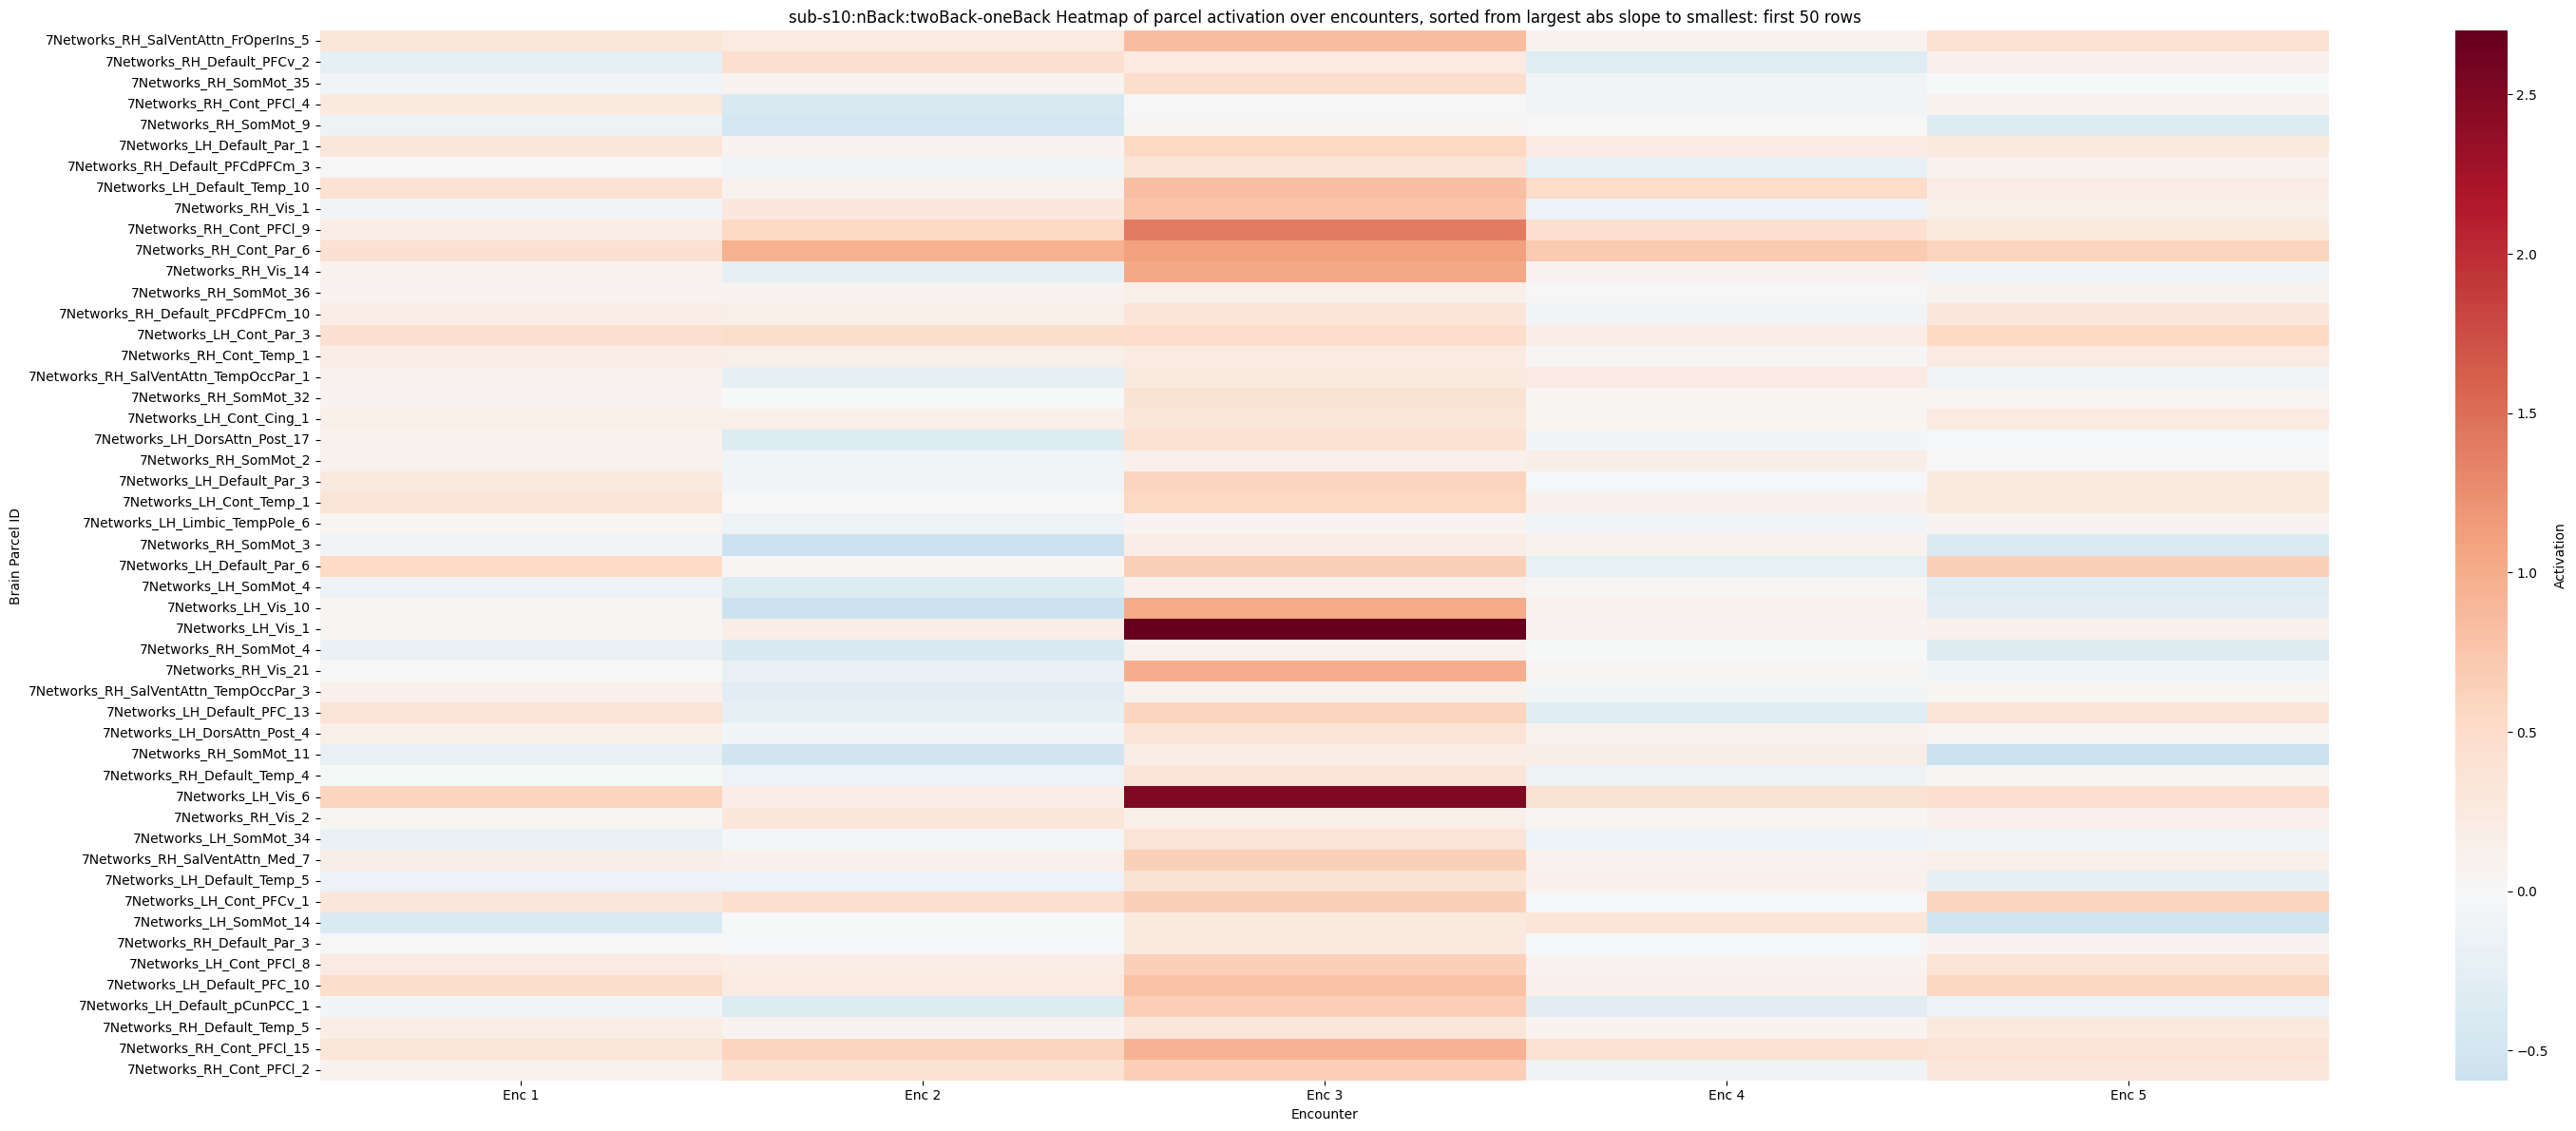

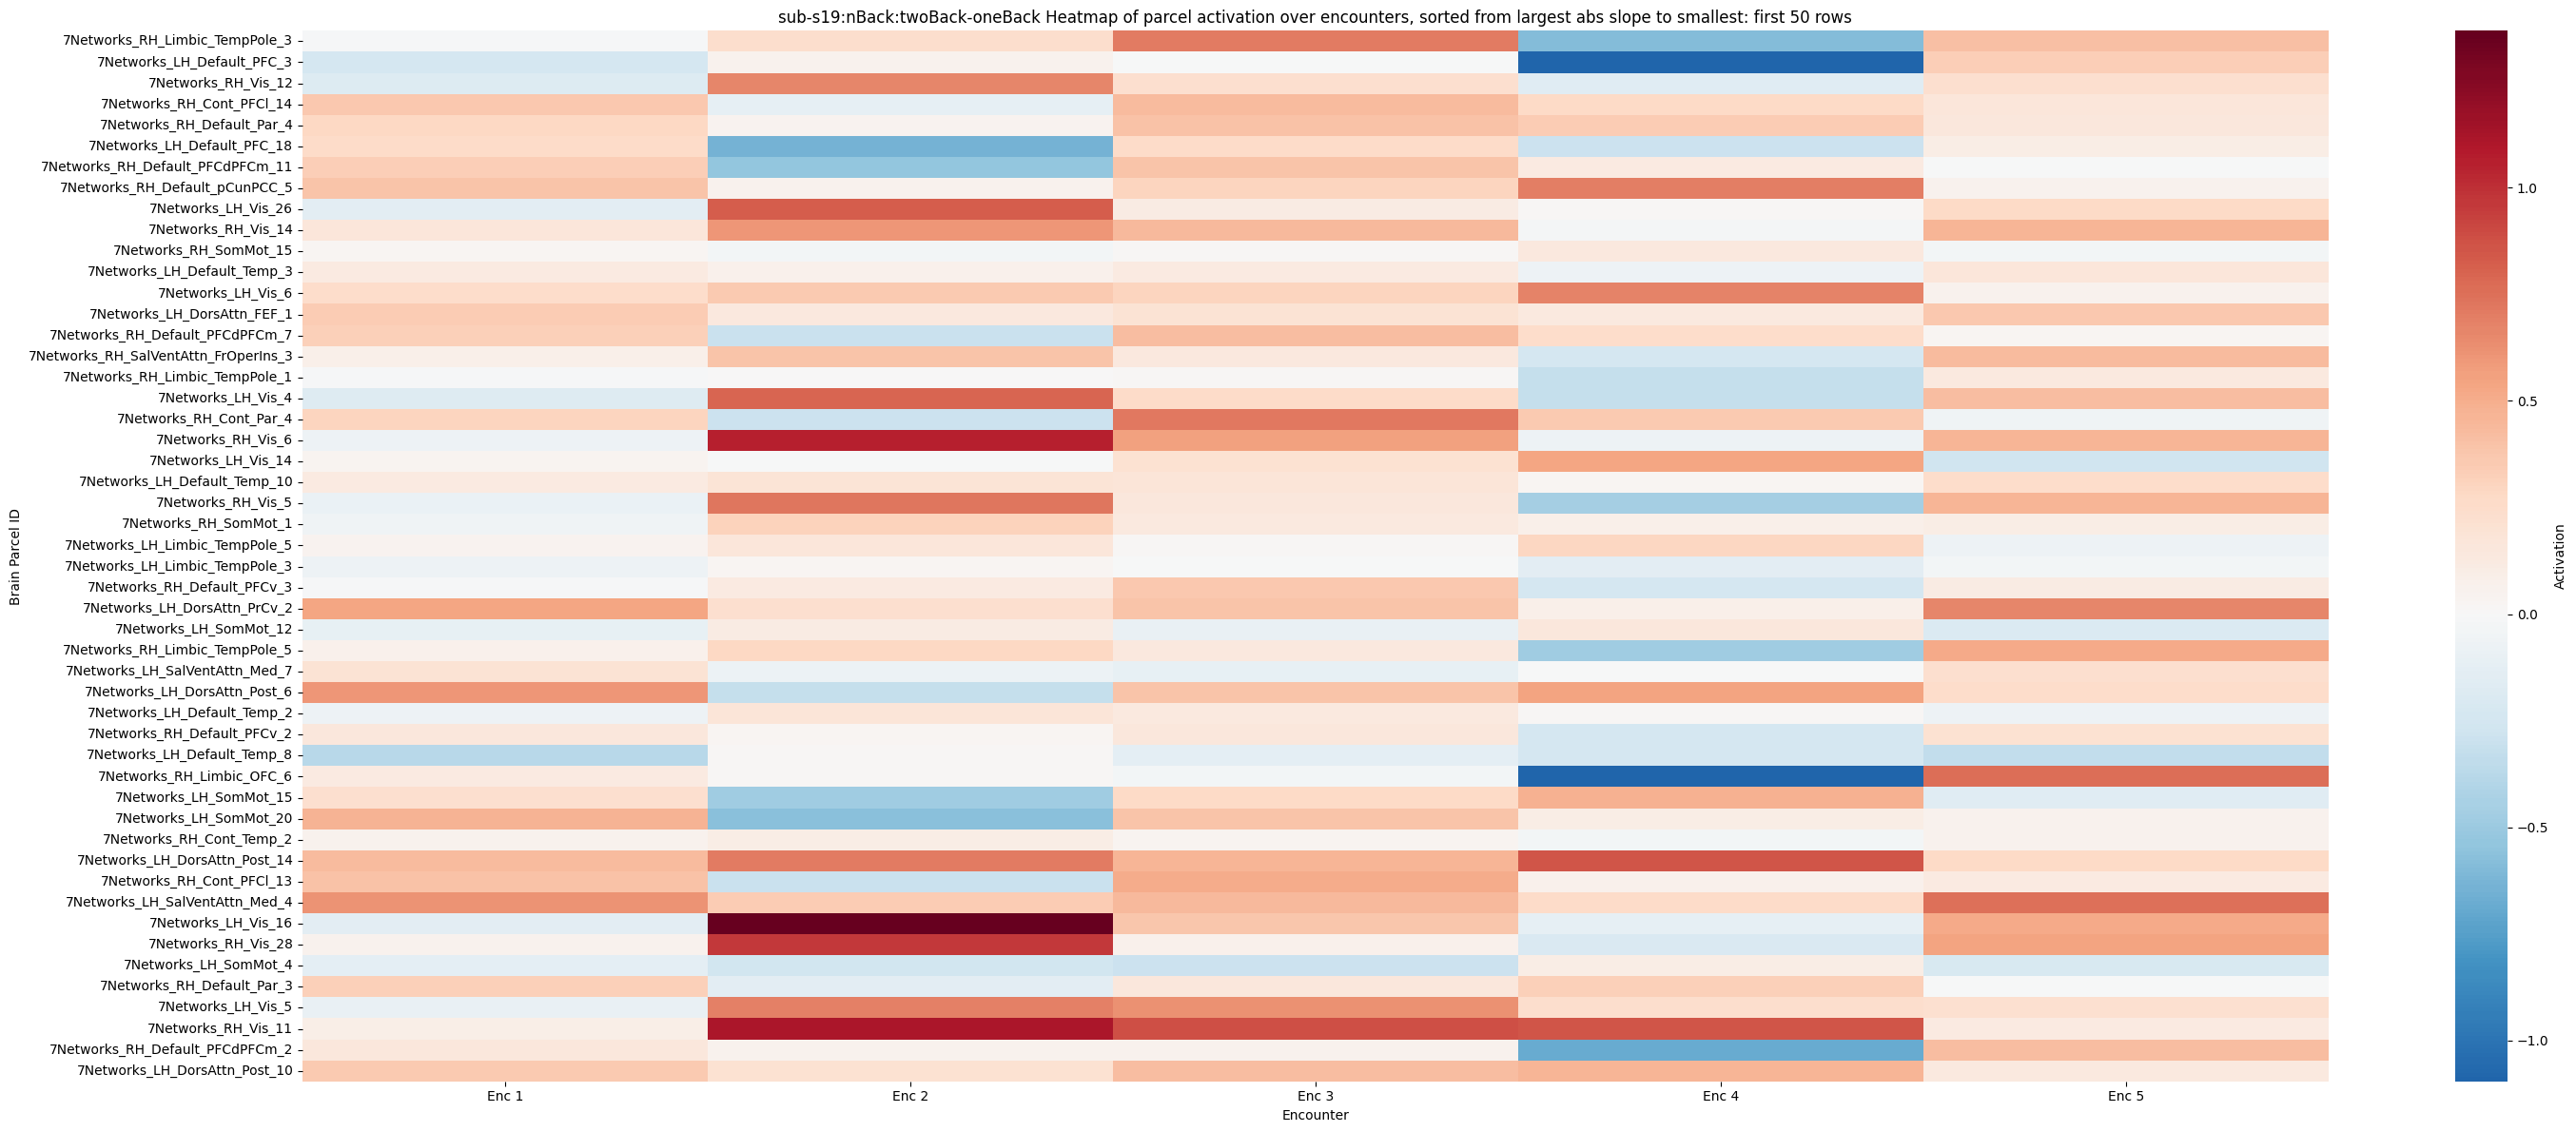

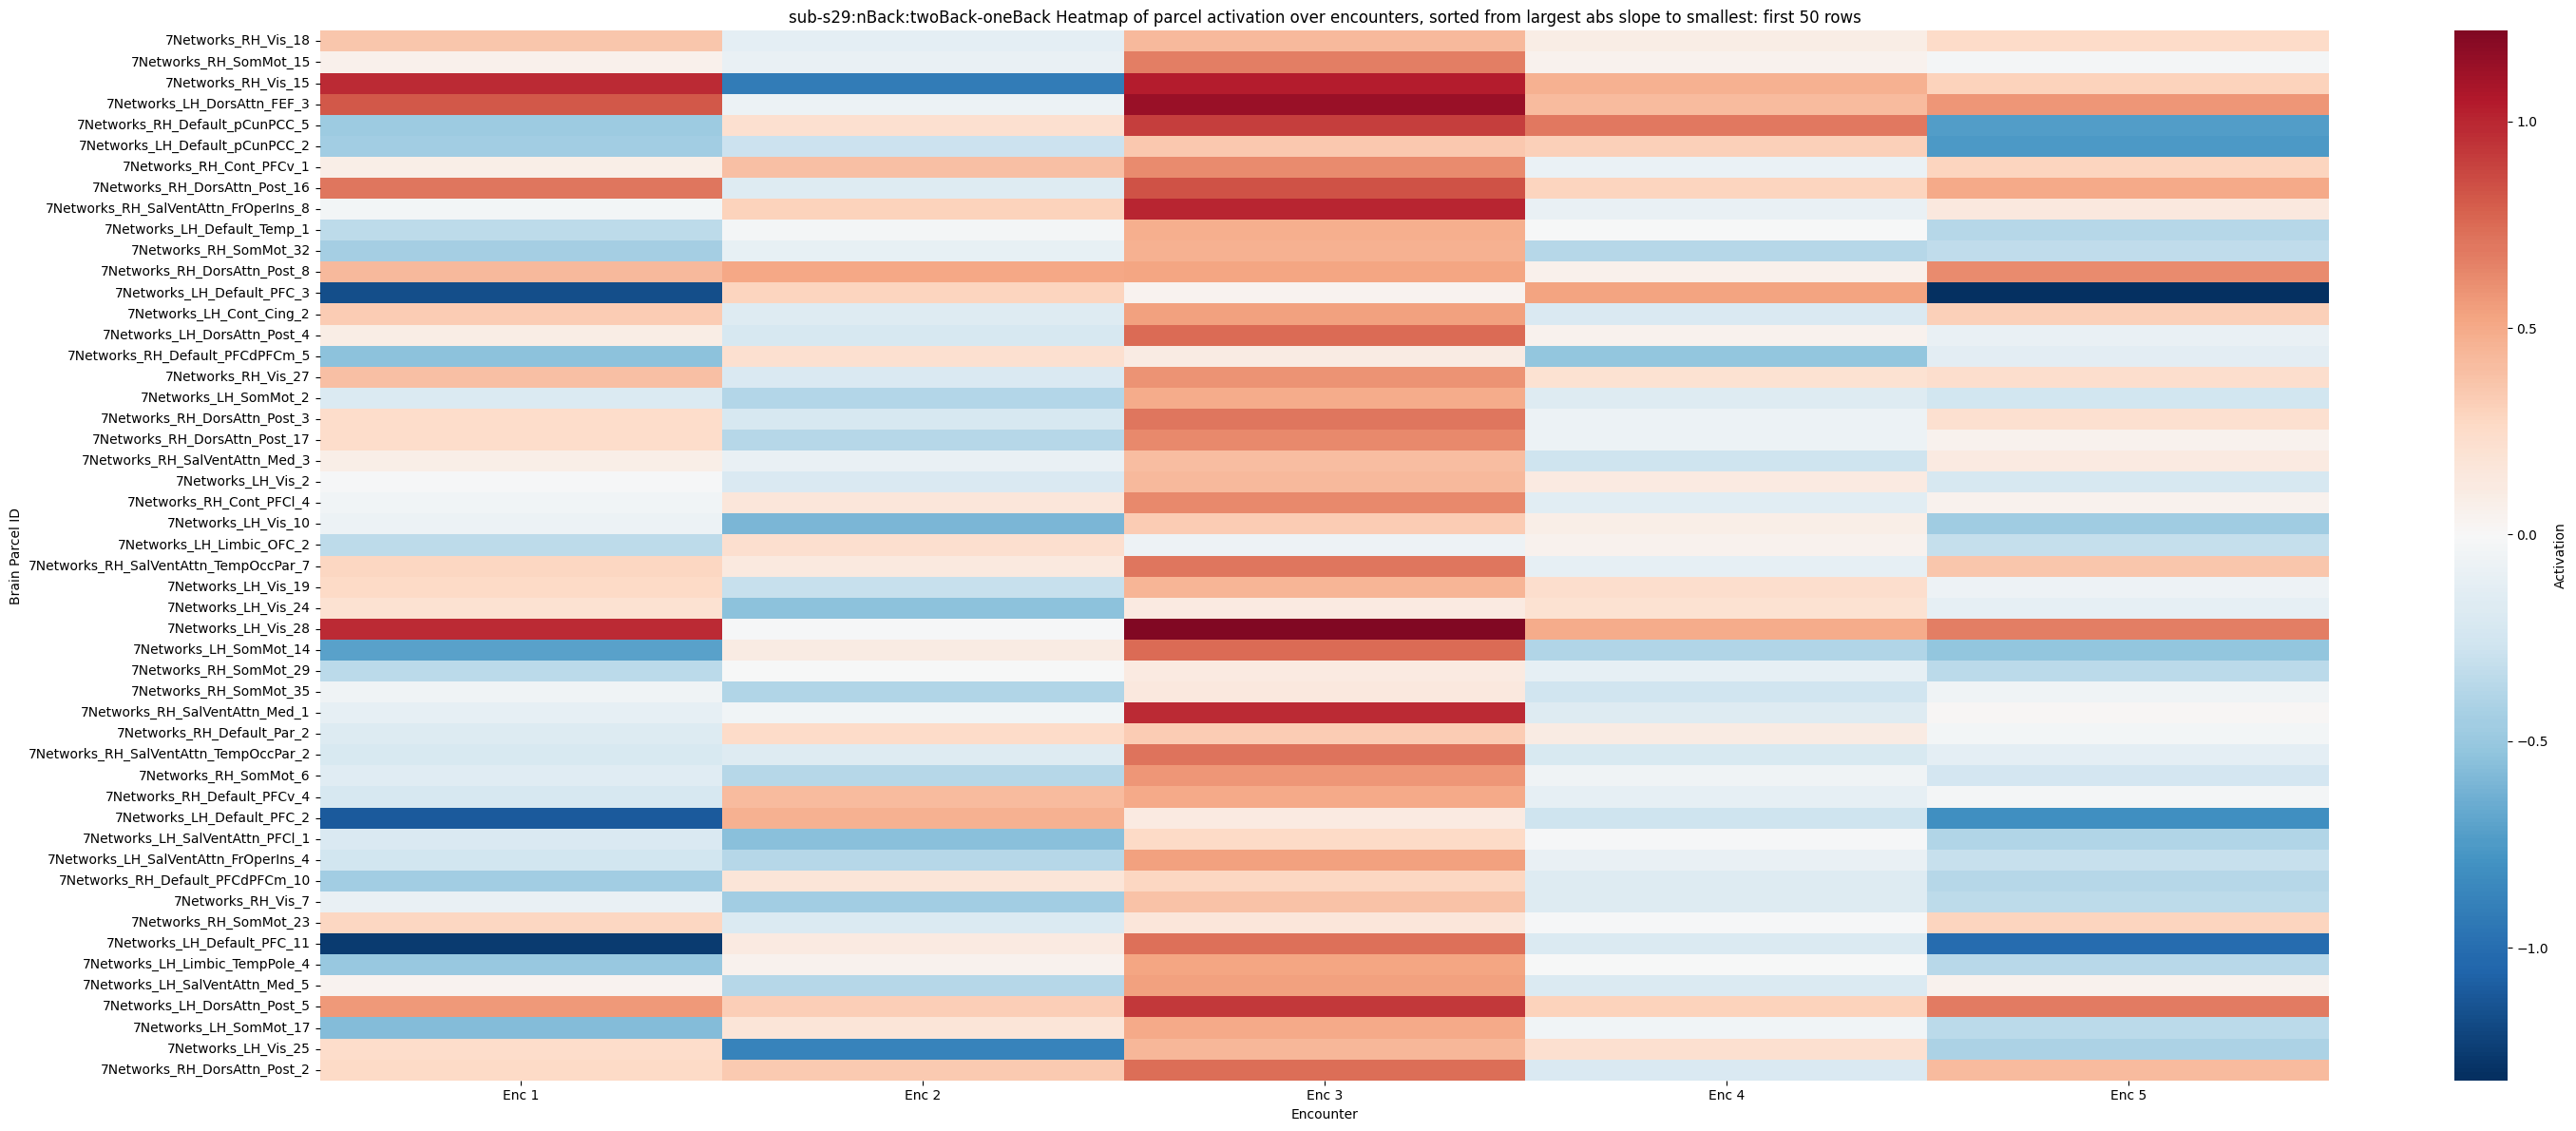

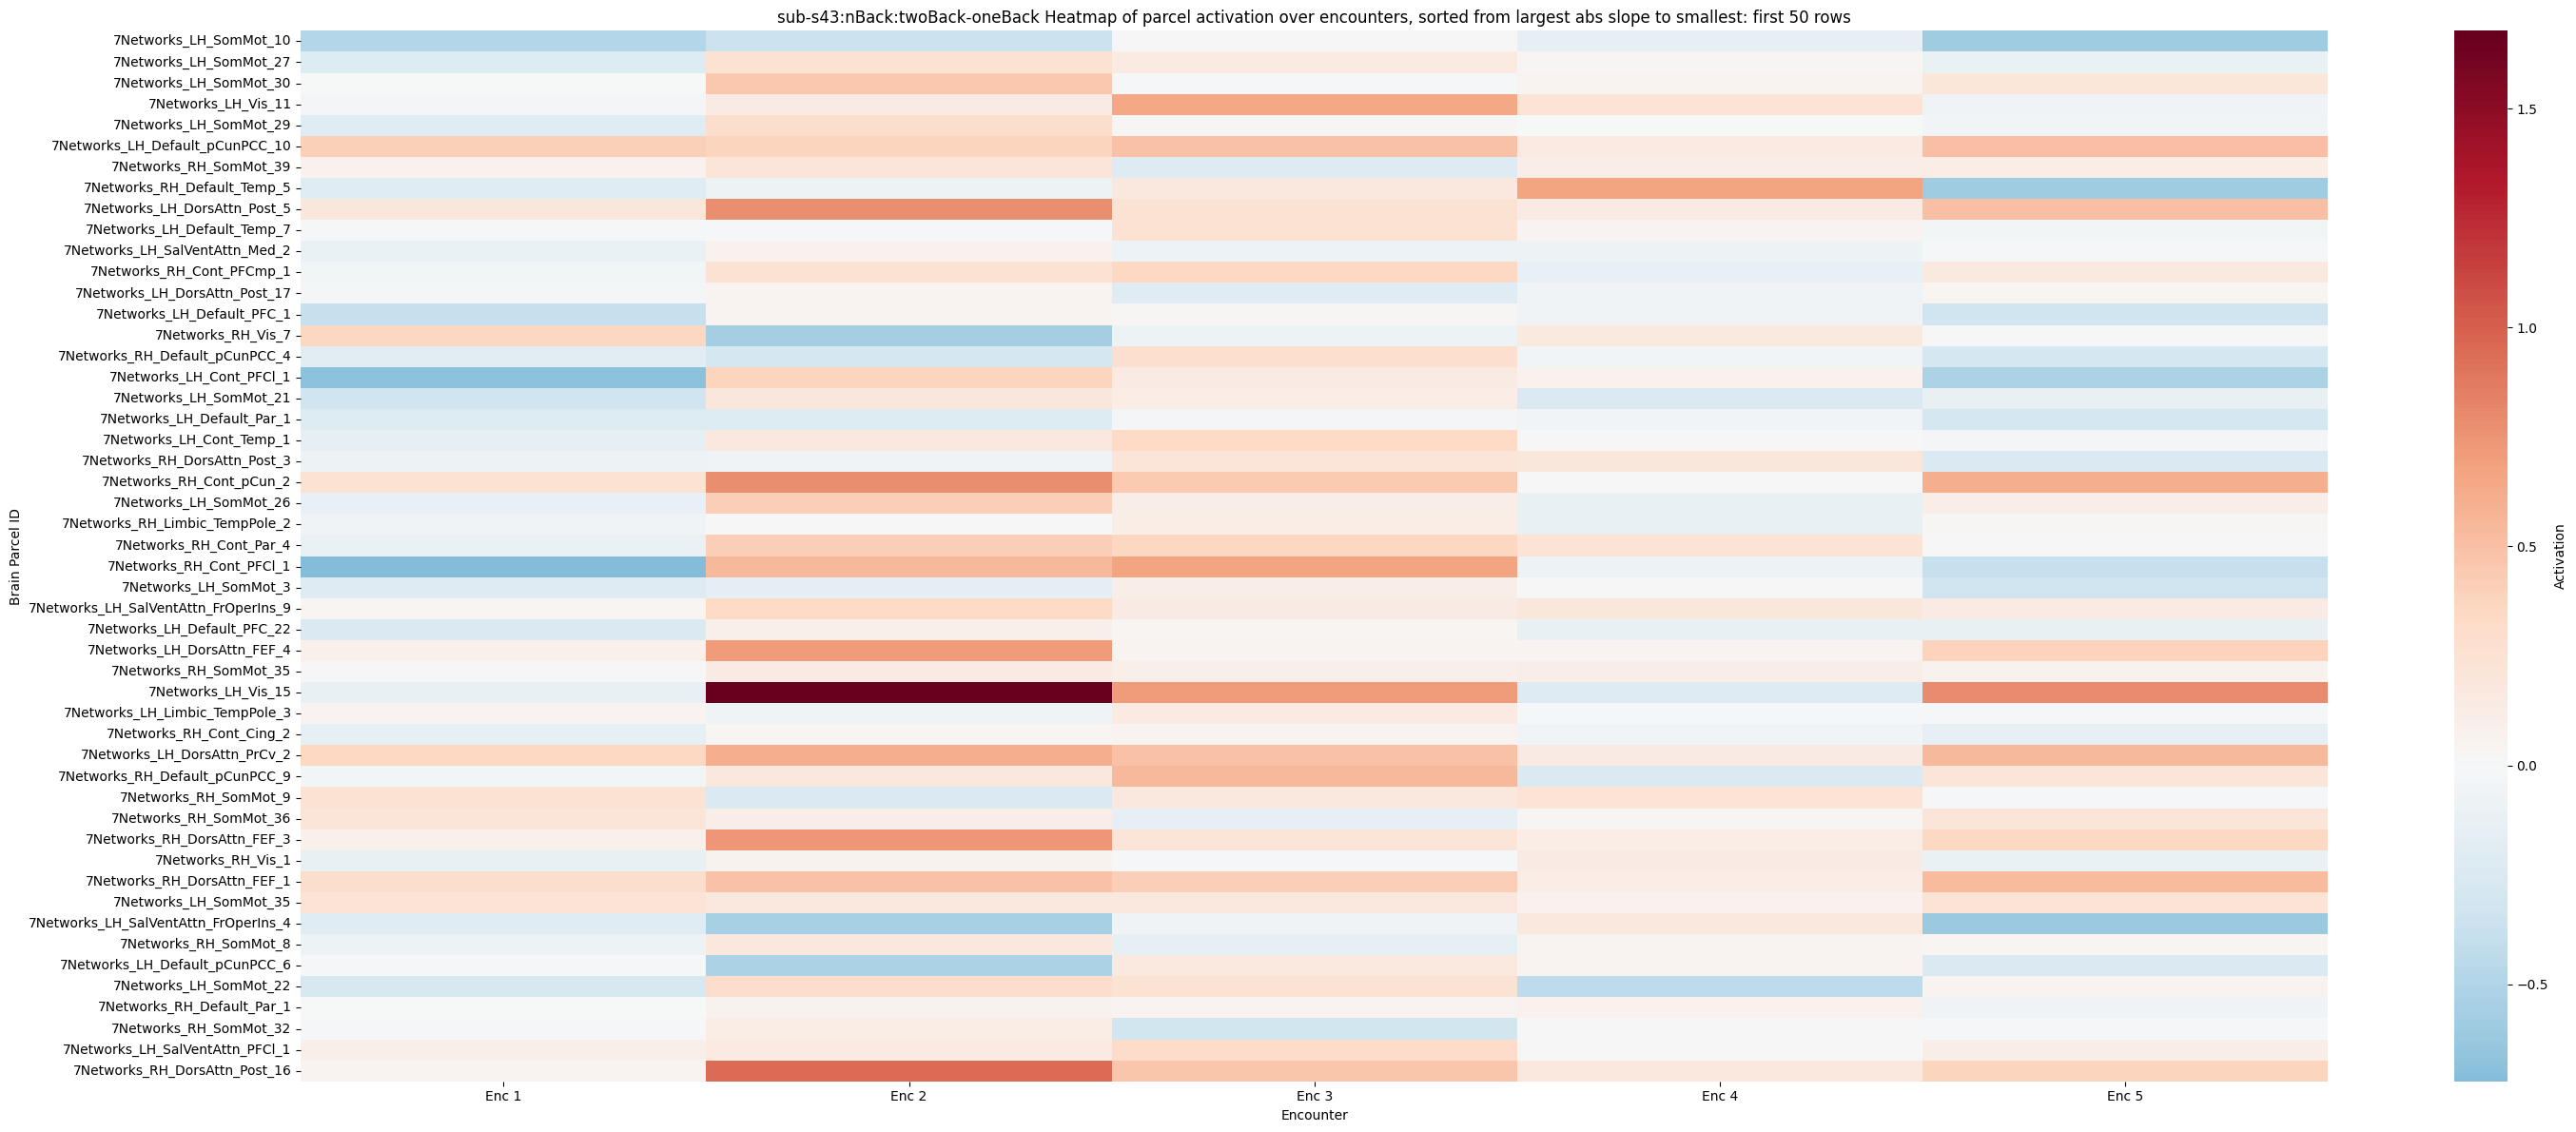

In [11]:
for subj in SUBJECTS:
    if (subj == "sub-s03"):
        continue
    task = "nBack"
    contrast = requested_task_contrasts[task][0]
    title = f"{subj}:{task}:{contrast} Heatmap of parcel activation over encounters, sorted from largest abs slope to smallest"

    create_parcel_practice_heatmap(parcel_traj_results[subj][task][contrast],title)

# group analysis

In [12]:
# create an averaged parcel df across all participants
avg_parcel_traj_results = {}

count_success = 0
for task in requested_task_contrasts:
    avg_parcel_traj_results[task] = {}

    for contrast in requested_task_contrasts[task]:
        print(f"Processing {task}/{contrast}:")
        avg_parcel_traj_results[task][contrast] = {}

        # Collect all parcel data across subjects
        parcel_data = defaultdict(list)
        
        for subj in SUBJECTS:
            if (subj == "sub-s03"):
                print(f"skipping {subj}")
                continue
            try:
                curr_res = parcel_traj_results[subj][task][contrast]
                
                # For each parcel in this subject's results
                for parcel_name, parcel_stats in curr_res.items():
                    parcel_data[parcel_name].append(parcel_stats)
                    
            except Exception as e:
                print(f"Error processing {subj}/{task}/{contrast}: {e}")
                continue

        
        # Calculate averages for each parcel
        for parcel_name, subject_data_list in parcel_data.items():
            if len(subject_data_list) == 0:
                continue
                
            # Collect all values across subjects for this parcel
            slopes = [data['slope'] for data in subject_data_list]
            intercepts = [data['intercept'] for data in subject_data_list]
            r_squareds = [data['r_squared'] for data in subject_data_list]
            p_values = [data['p_value'] for data in subject_data_list]
            std_errors = [data['std_error'] for data in subject_data_list]
            initial_activations = [data['initial_activation'] for data in subject_data_list]
            final_activations = [data['final_activation'] for data in subject_data_list]
            percent_changes = [data['percent_change'] for data in subject_data_list]
            cohens_ds = [data['cohens_d'] for data in subject_data_list]
            max_activations = [data['max_activation'] for data in subject_data_list]
            min_activations = [data['min_activation'] for data in subject_data_list]
            activation_ranges = [data['activation_range'] for data in subject_data_list]
            trajectories = [data['trajectory'] for data in subject_data_list]


            # calculate trajectory vals since diff contrasts/subj have different numbers of encounters
            if len(trajectories) > 0:
                # Check if all trajectories are the same length
                trajectory_lengths = [len(traj) for traj in trajectories]
                
                if len(set(trajectory_lengths)) == 1:
                    # All same length
                    trajectory_array = np.array(trajectories)
                    trajectory_mean = np.mean(trajectory_array, axis=0)
                    trajectory_std = np.std(trajectory_array, axis=0)
                    trajectory_sem = trajectory_std / np.sqrt(len(trajectories))
                else:
                    # Different lengths - use padding
                    max_length = max(trajectory_lengths)
                    padded_trajectories = []
                    
                    for traj in trajectories:
                        if len(traj) < max_length:
                            padded = np.full(max_length, np.nan)
                            padded[:len(traj)] = traj
                            padded_trajectories.append(padded)
                        else:
                            padded_trajectories.append(traj)
                    
                    trajectory_array = np.array(padded_trajectories)
                    trajectory_mean = np.nanmean(trajectory_array, axis=0)
                    trajectory_std = np.nanstd(trajectory_array, axis=0)
                    n_valid = np.sum(~np.isnan(trajectory_array), axis=0)
                    trajectory_sem = trajectory_std / np.sqrt(n_valid)
        
            # Calculate averages and statistics
            avg_parcel_traj_results[task][contrast][parcel_name] = {
                'n_subjects': len(subject_data_list),
                
                # Slope statistics
                'slope_mean': np.mean(slopes),
                'slope_std': np.std(slopes),
                # 'slope_sem': np.std(slopes) / np.sqrt(len(slopes)) if len(slopes) > 0 else 0,
                
                # Other key metrics
                'intercept_mean': np.mean(intercepts),
                'r_squared_mean': np.mean(r_squareds),
                'p_value_mean': np.mean(p_values),
                
                # Activation statistics
                'initial_activation_mean': np.mean(initial_activations),
                'initial_activation_std': np.std(initial_activations),
                'final_activation_mean': np.mean(final_activations),
                'final_activation_std': np.std(final_activations),
                
                # Change metrics
                'percent_change_mean': np.mean(percent_changes),
                'percent_change_std': np.std(percent_changes),
                'cohens_d_mean': np.mean(cohens_ds),
                
                # Range metrics
                'max_activation_mean': np.mean(max_activations),
                'min_activation_mean': np.mean(min_activations),
                'activation_range_mean': np.mean(activation_ranges),
                
                # # Trajectory information
                'trajectory_mean': trajectory_mean,
                'trajectory_std': trajectory_std,
                'trajectory_sem': trajectory_sem,
                
                # Summary proportions
                'significant_slope_proportion': np.mean([1 if p < 0.05 else 0 for p in p_values]),
                'positive_slope_proportion': np.mean([1 if s > 0 else 0 for s in slopes]),
                'large_change_proportion': np.mean([1 if abs(pc) > 10 else 0 for pc in percent_changes]),
            }
        
        print(f"Completed averaging for {len(avg_parcel_traj_results[task][contrast])} parcels for {task}/{contrast}")
        count_success += 1

print(f"Averaging complete! for {count_success} task/contrasts")

Processing nBack/twoBack-oneBack:
skipping sub-s03
Completed averaging for 400 parcels for nBack/twoBack-oneBack
Processing nBack/task-baseline:
skipping sub-s03
Completed averaging for 400 parcels for nBack/task-baseline
Processing flanker/incongruent-congruent:
skipping sub-s03
Completed averaging for 400 parcels for flanker/incongruent-congruent
Processing flanker/task-baseline:
skipping sub-s03
Completed averaging for 400 parcels for flanker/task-baseline
Processing directedForgetting/neg-con:
skipping sub-s03
Completed averaging for 400 parcels for directedForgetting/neg-con
Processing directedForgetting/task-baseline:
skipping sub-s03
Completed averaging for 400 parcels for directedForgetting/task-baseline
Processing goNogo/nogo_success-go:
skipping sub-s03
Completed averaging for 400 parcels for goNogo/nogo_success-go
Processing goNogo/task-baseline:
skipping sub-s03
Completed averaging for 400 parcels for goNogo/task-baseline
Processing shapeMatching/main_vars:
skipping sub-s03

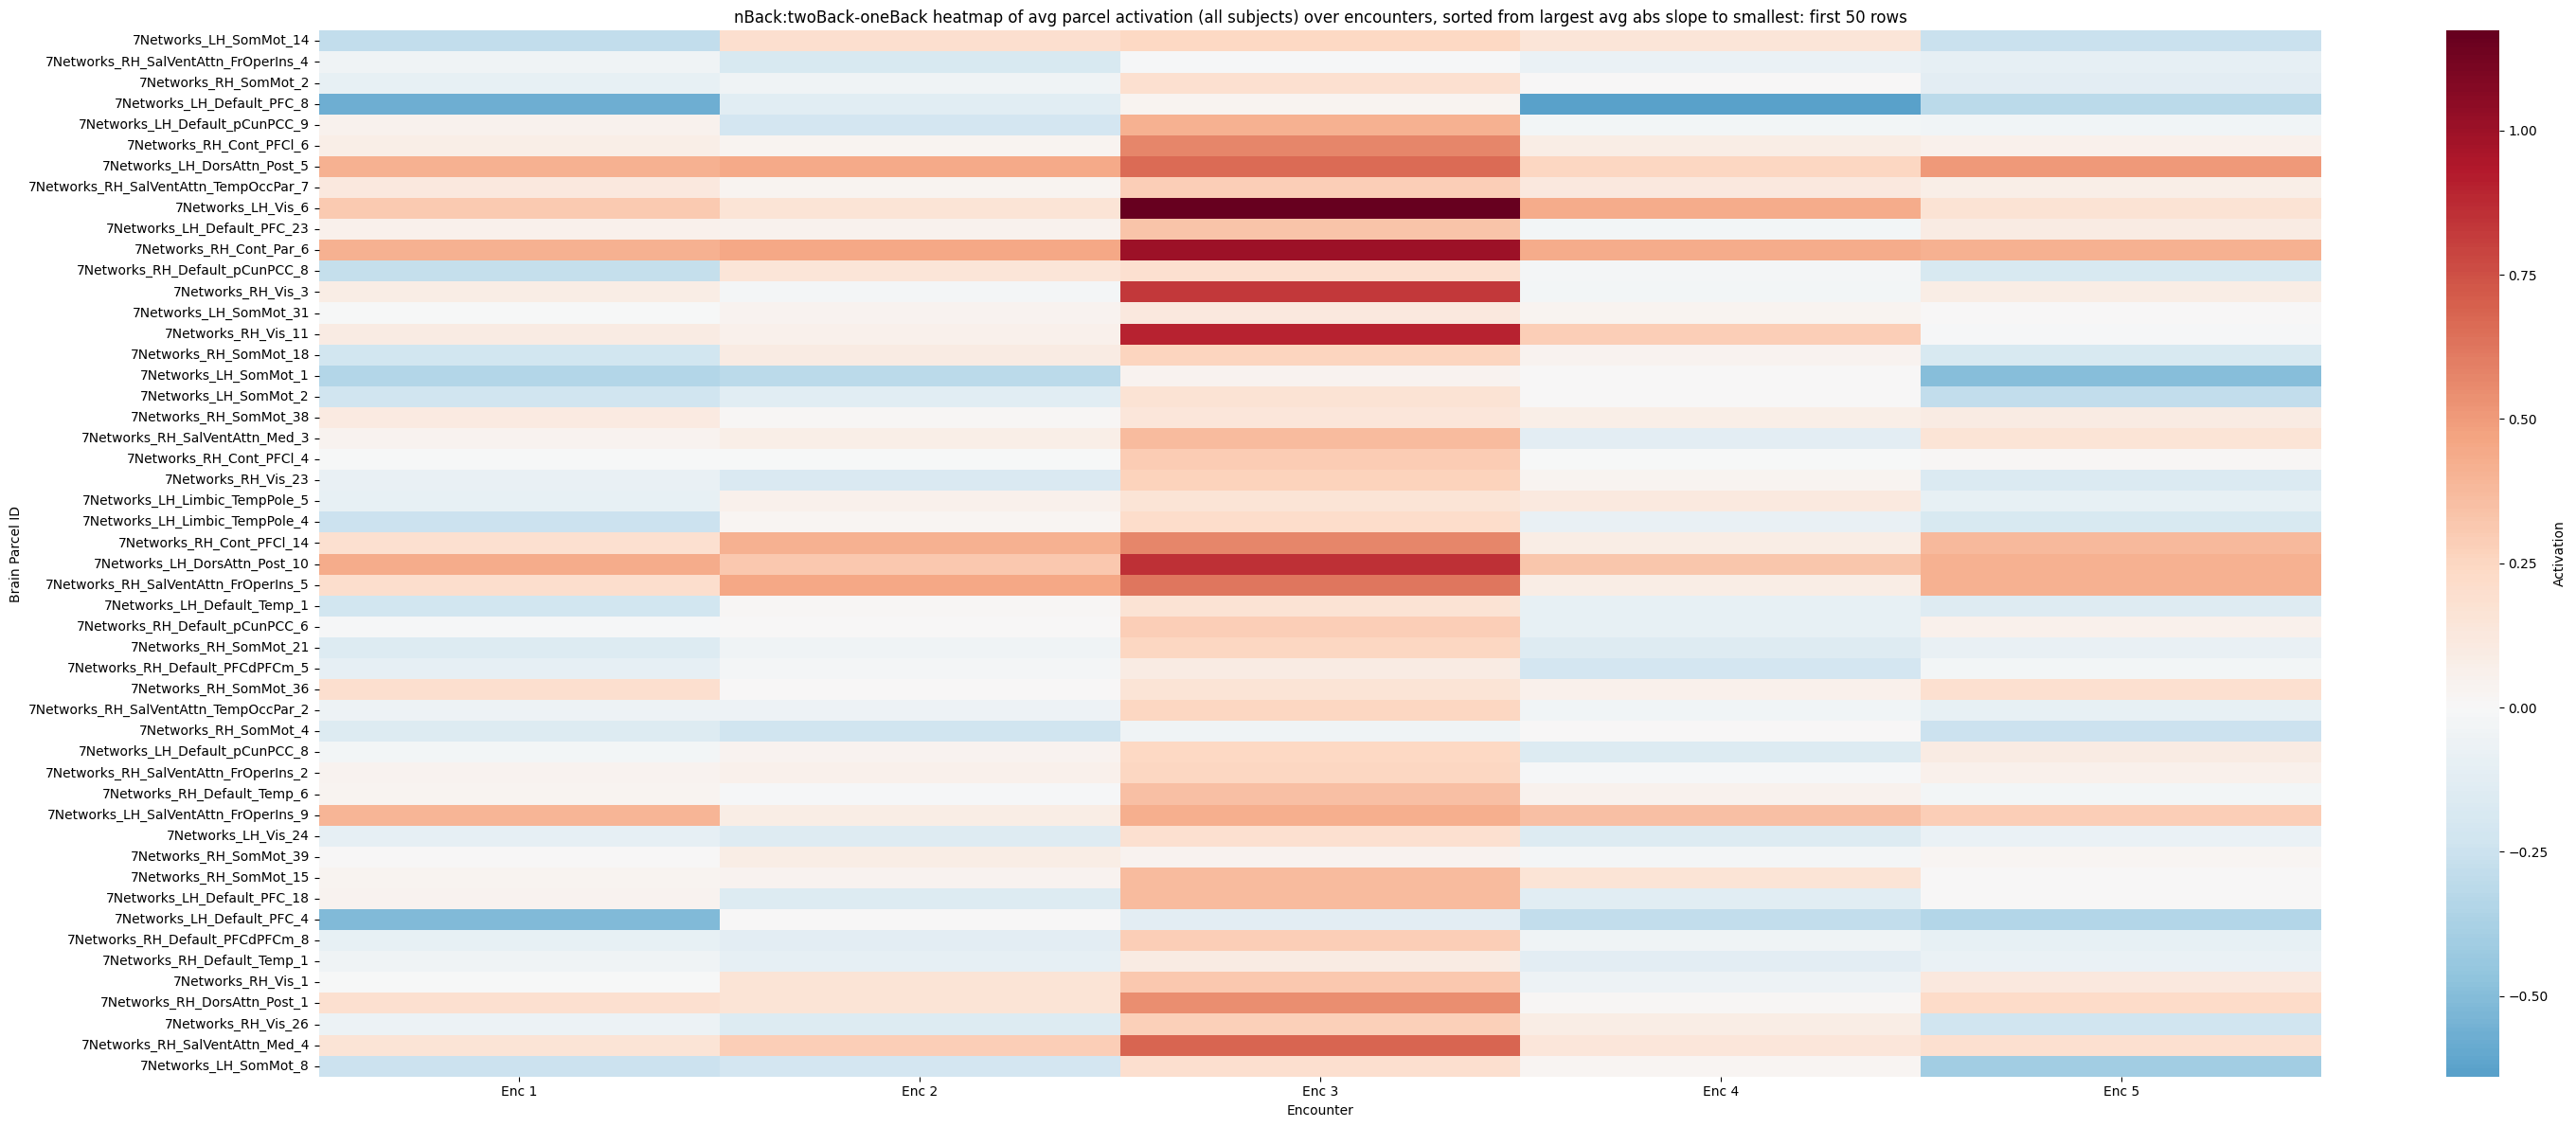

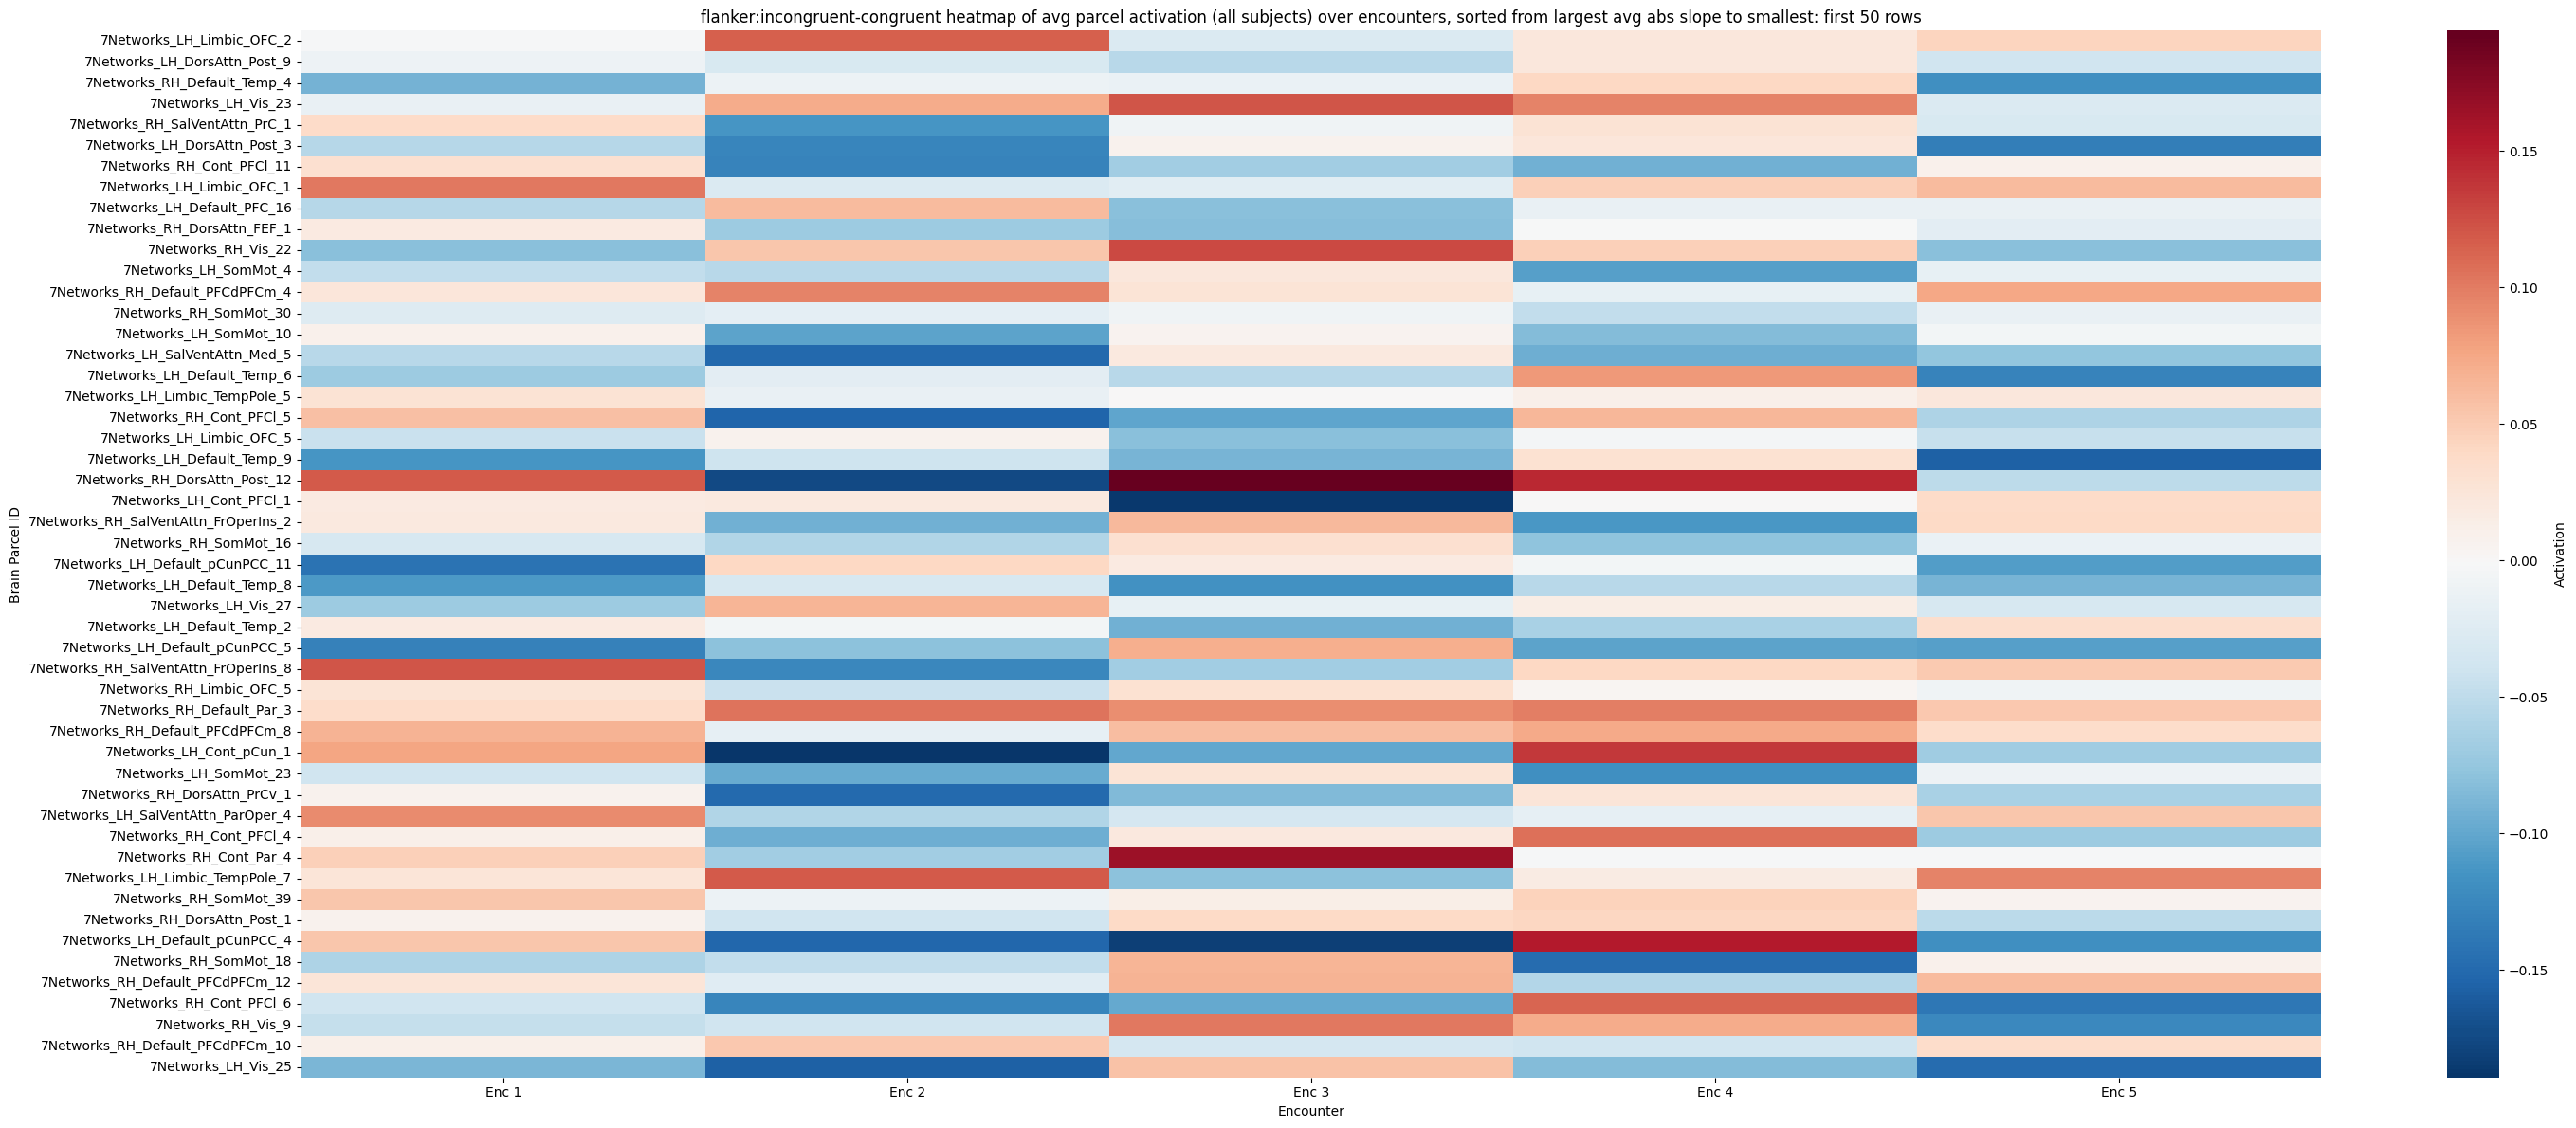

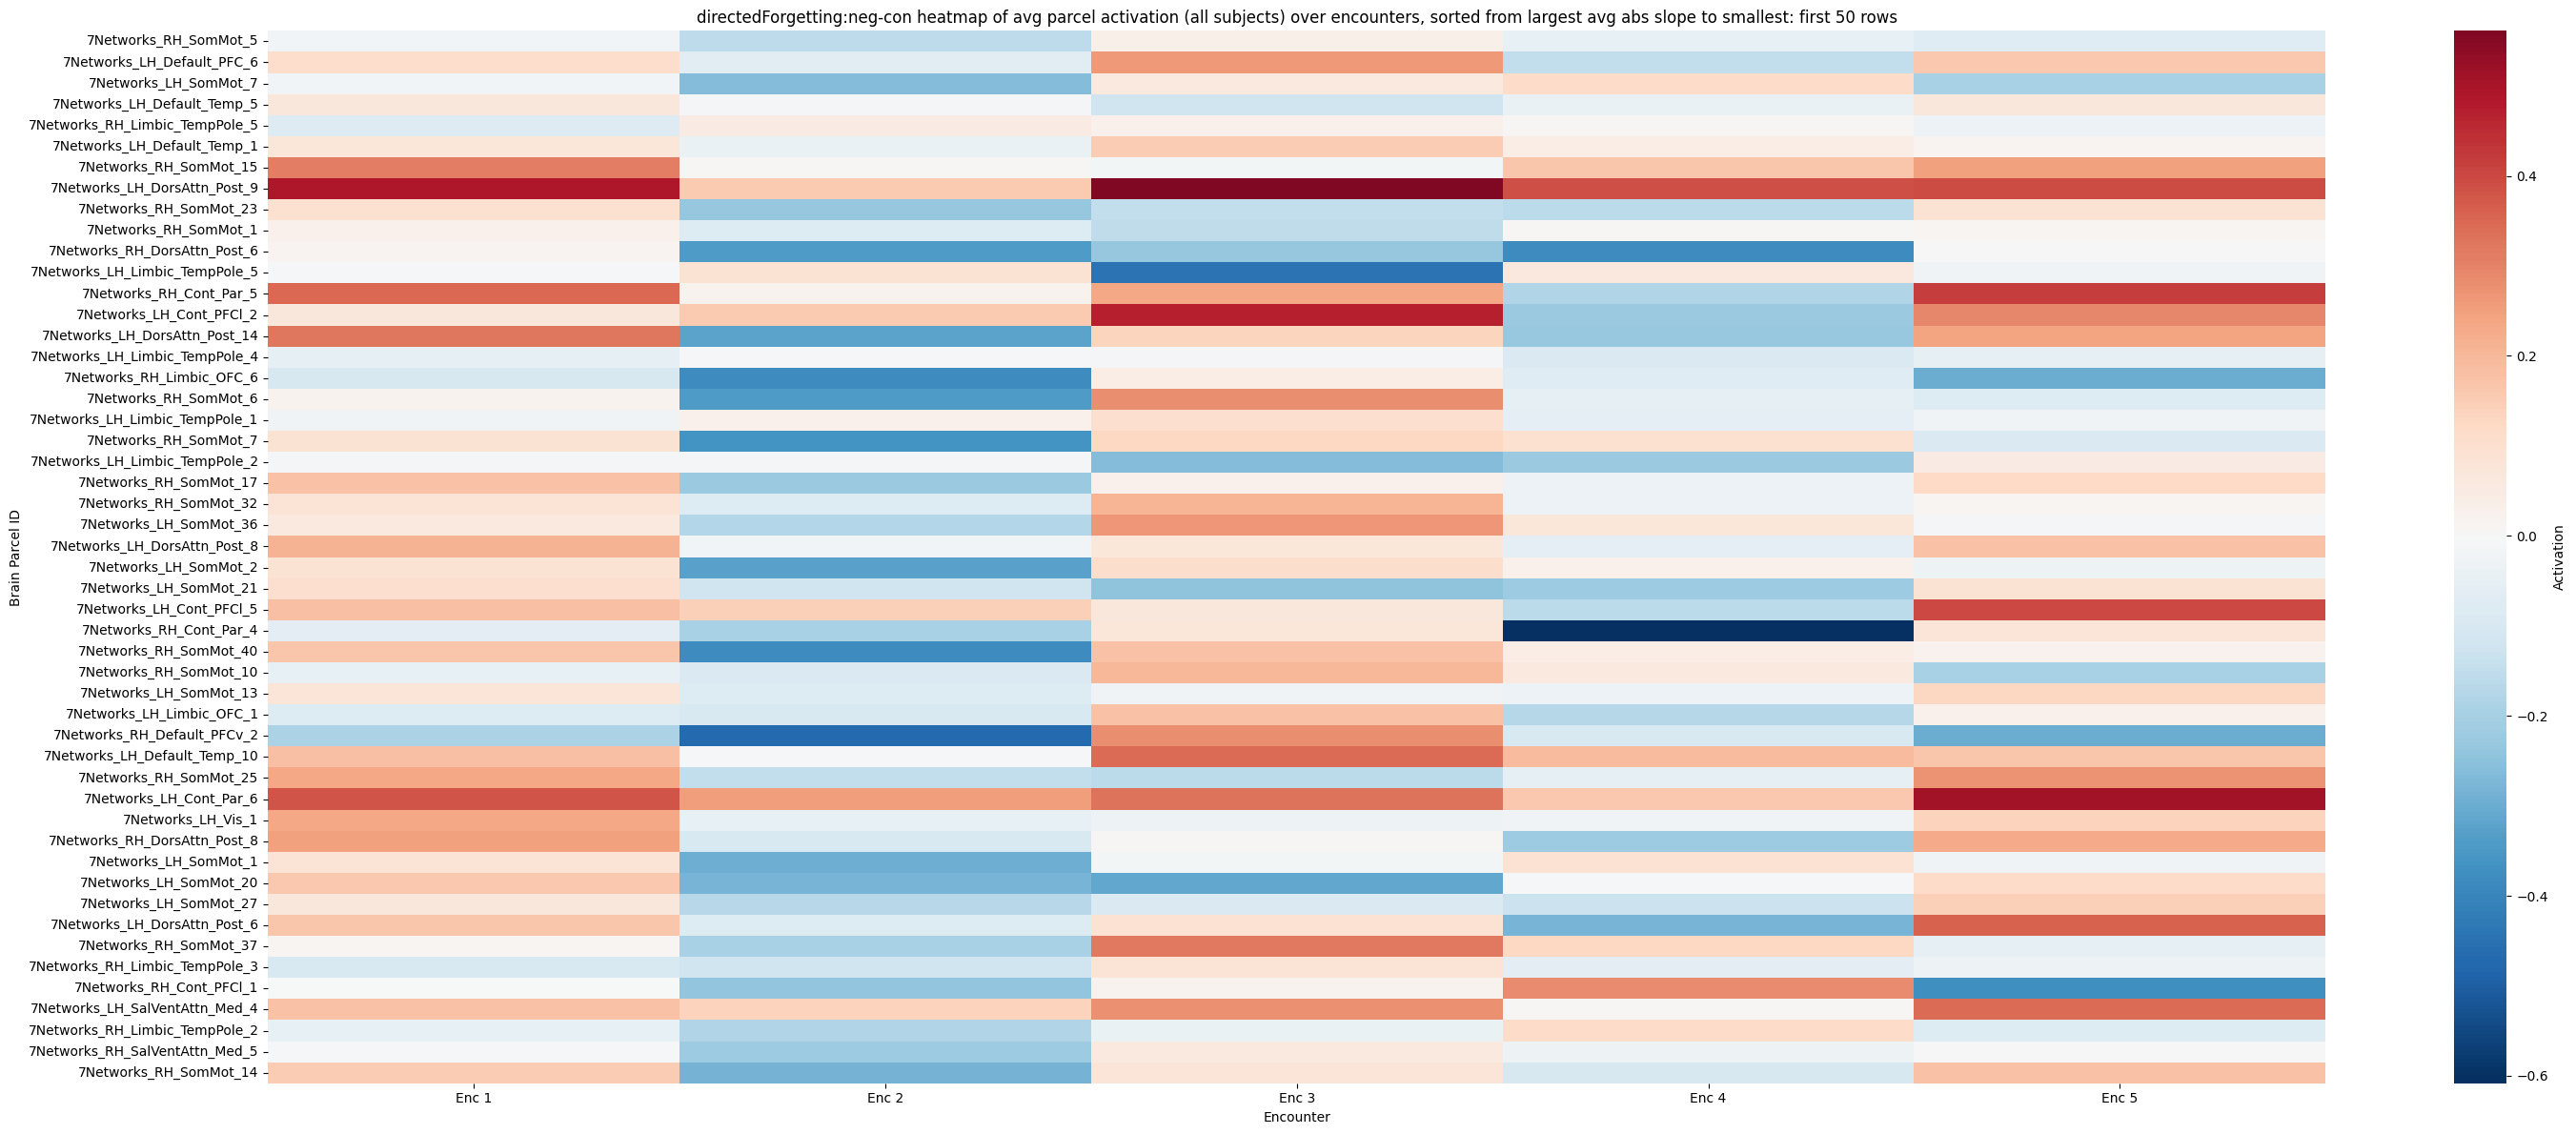

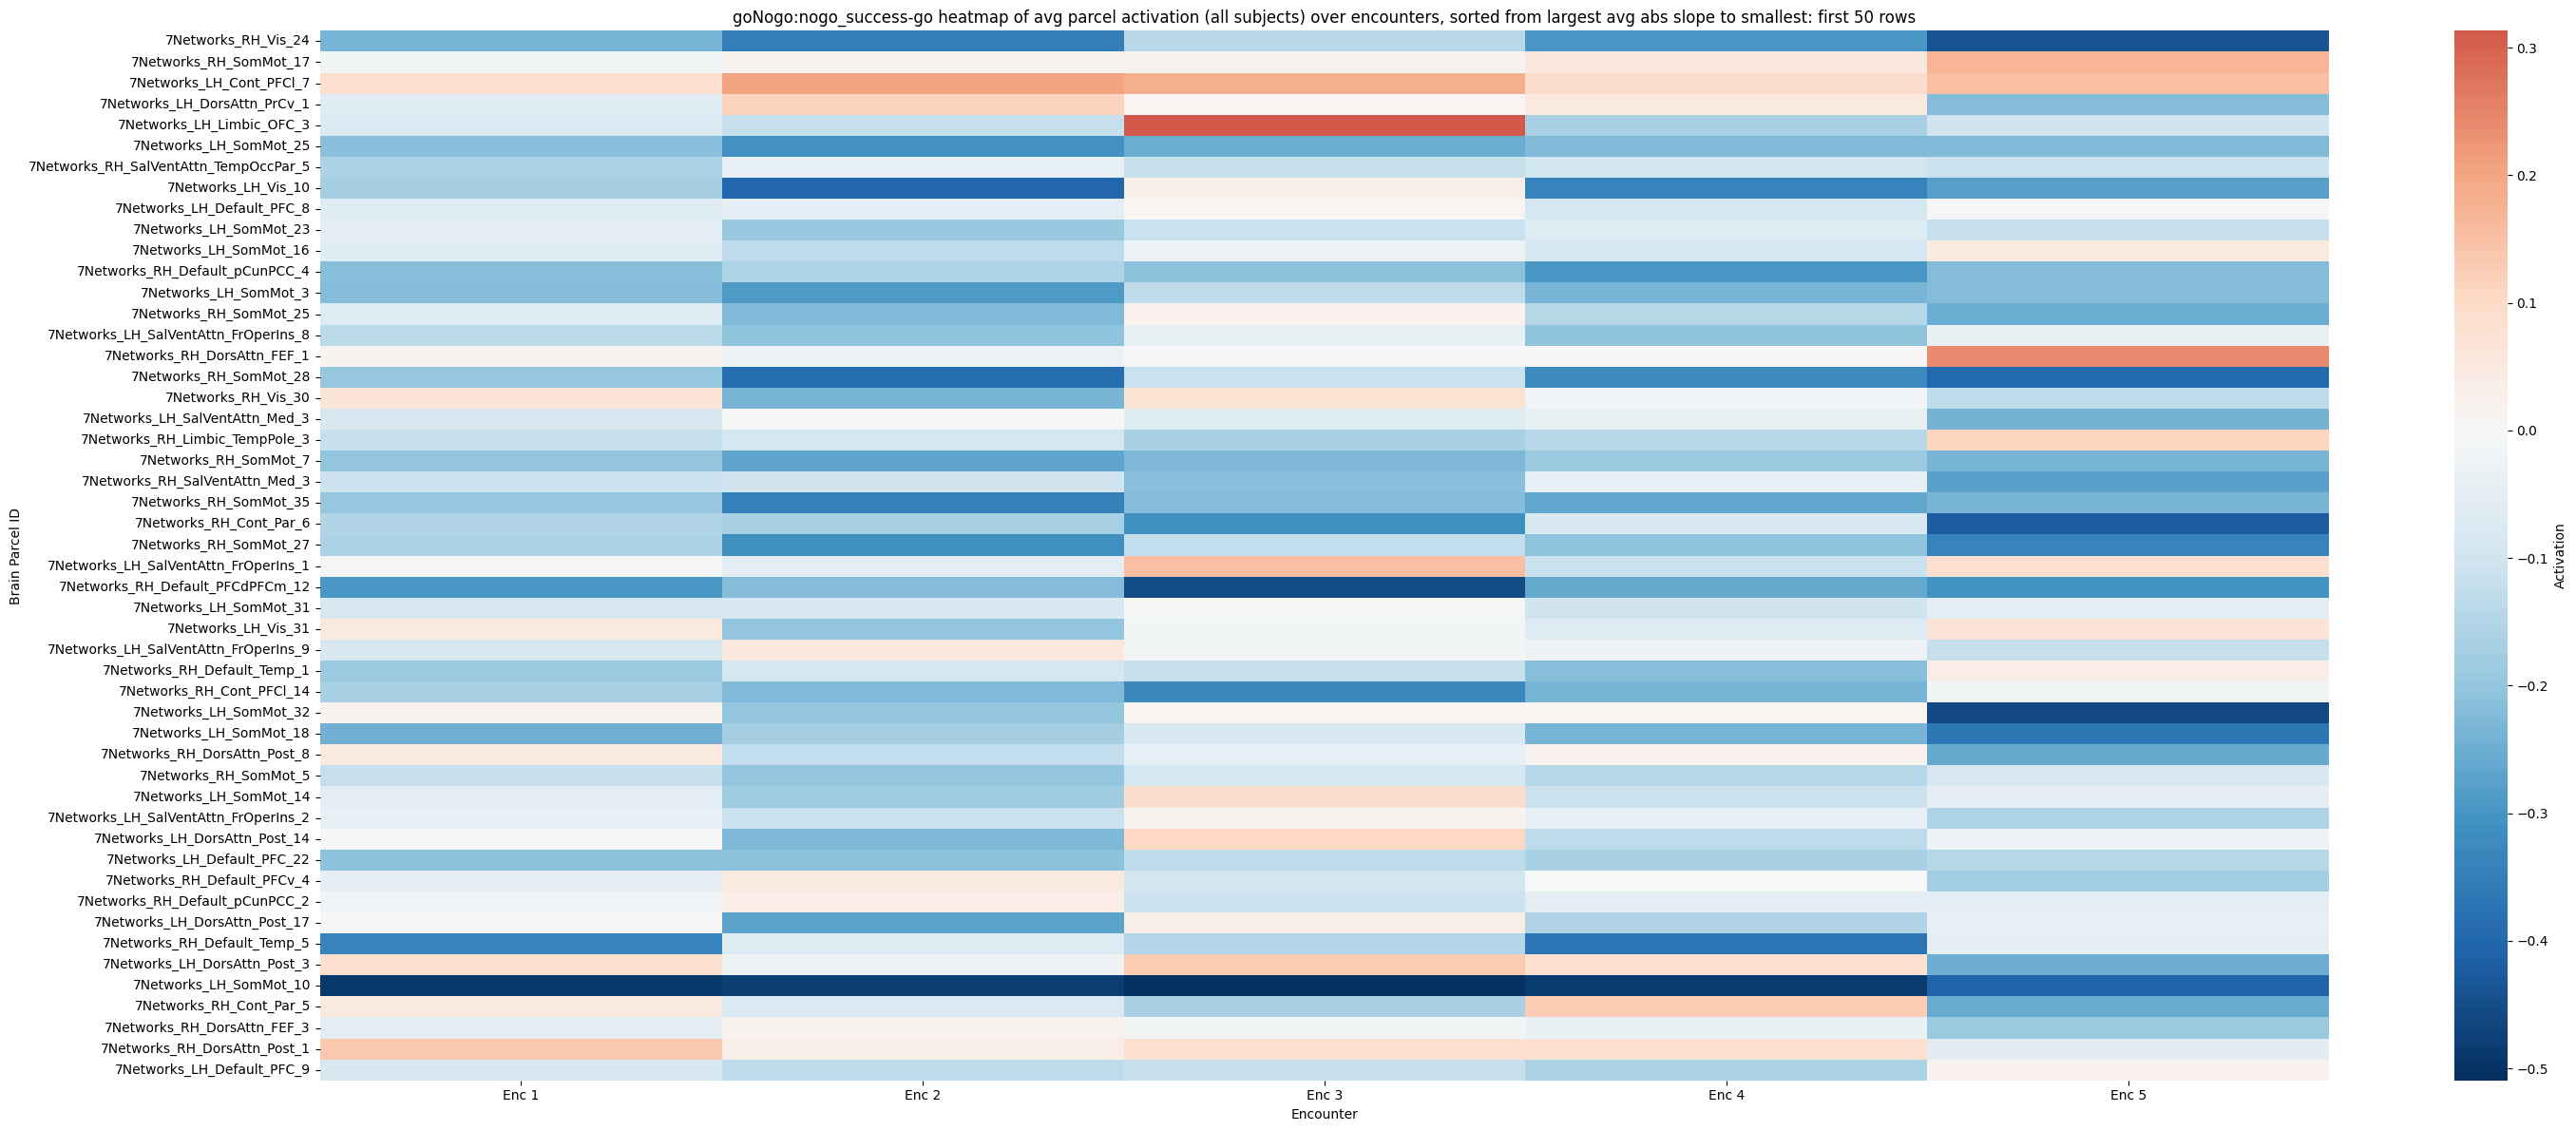

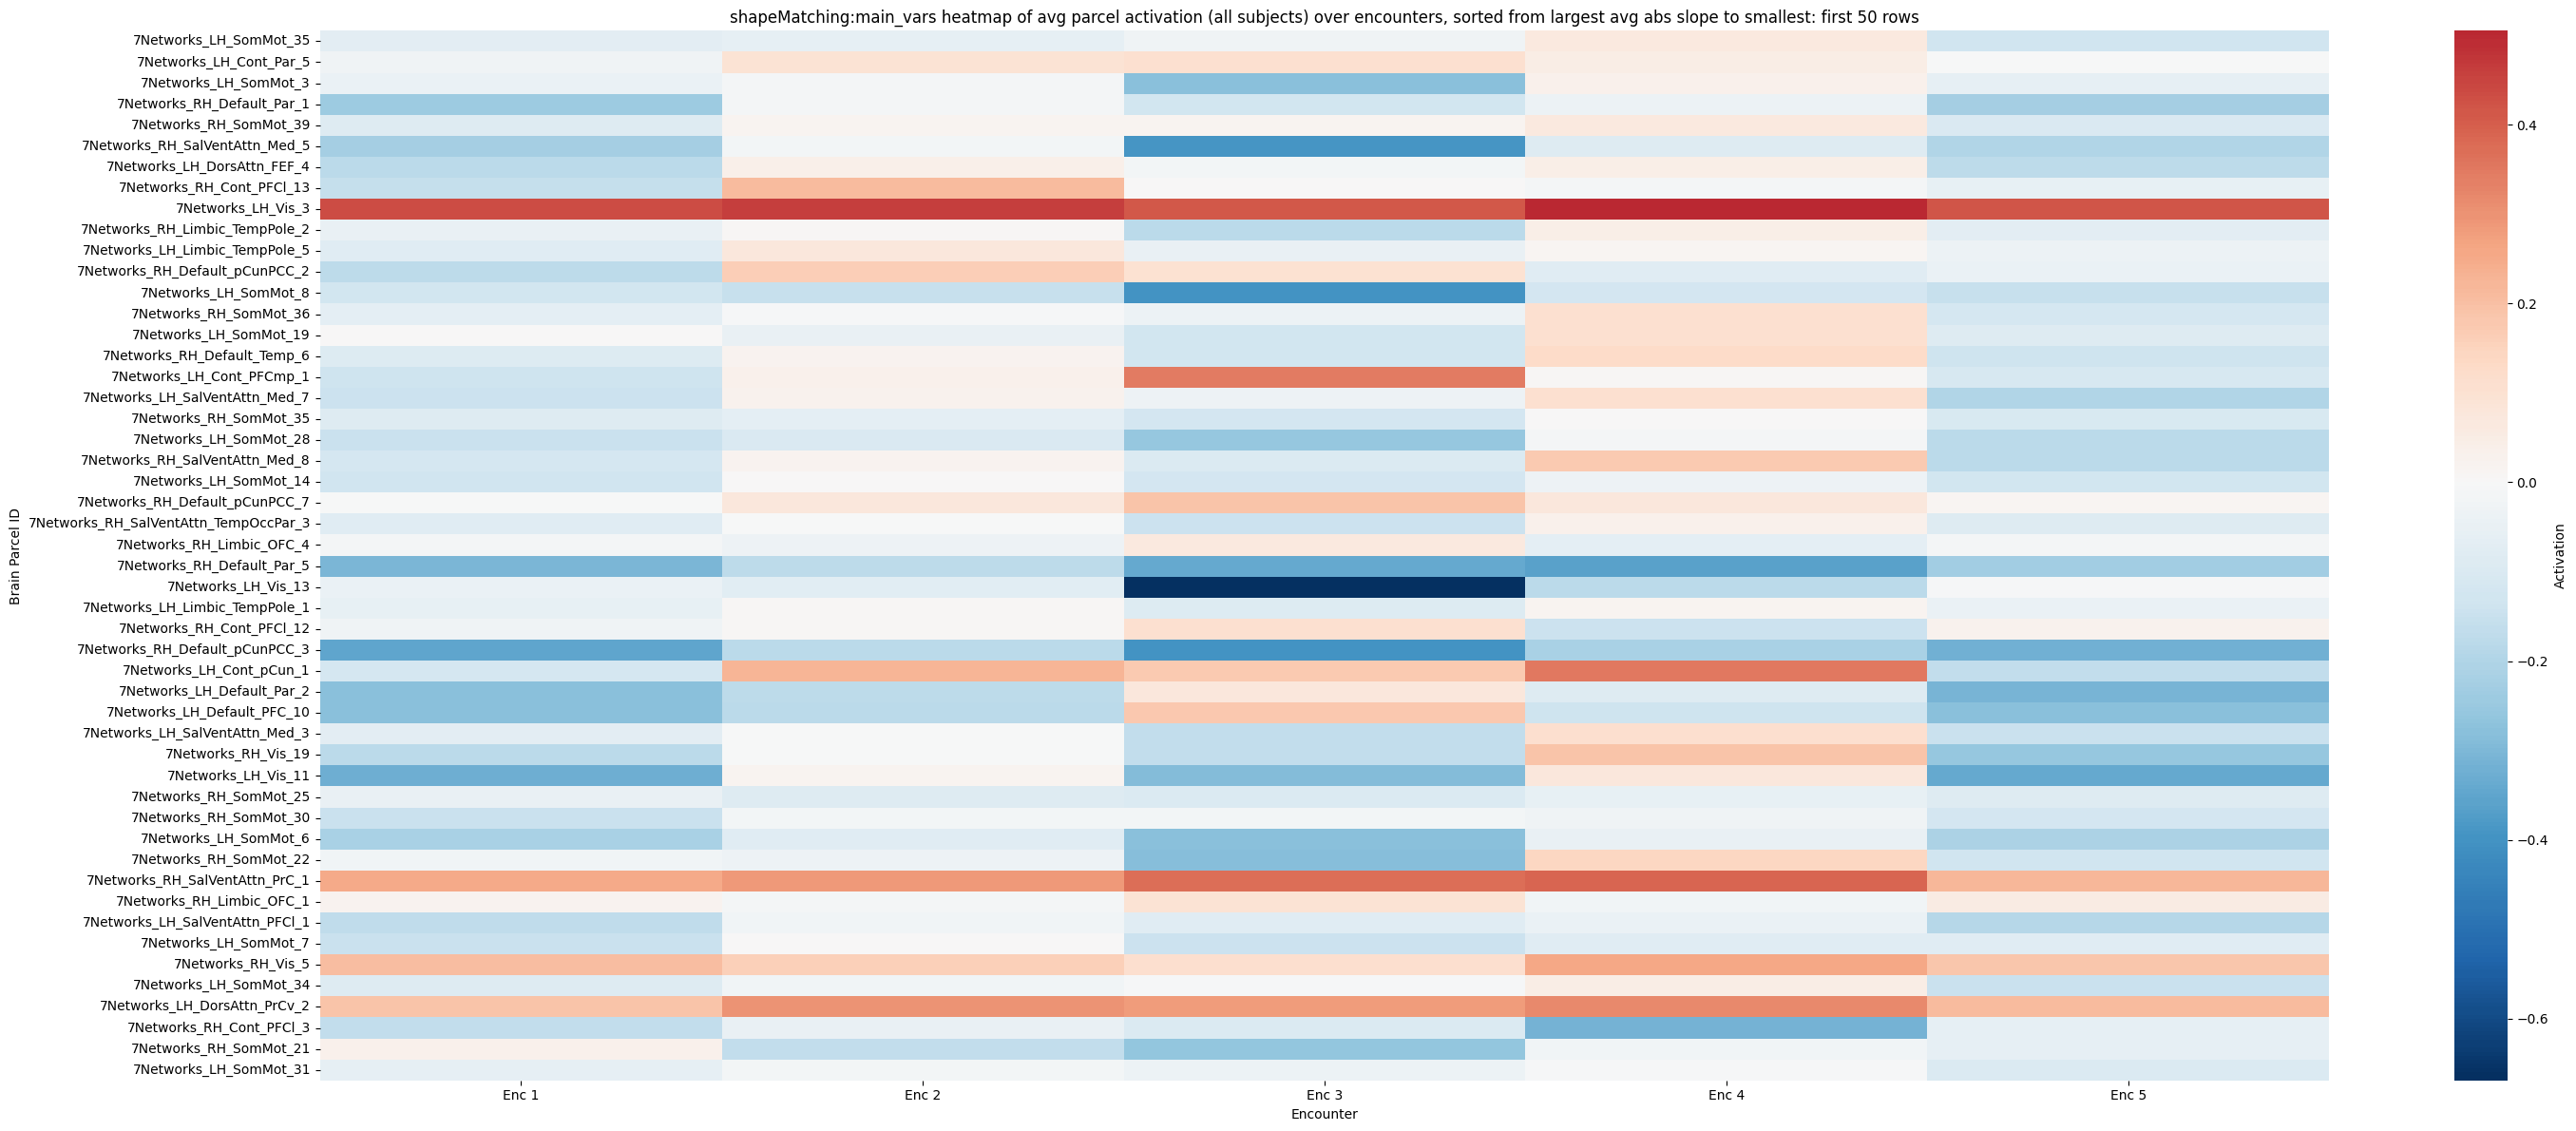

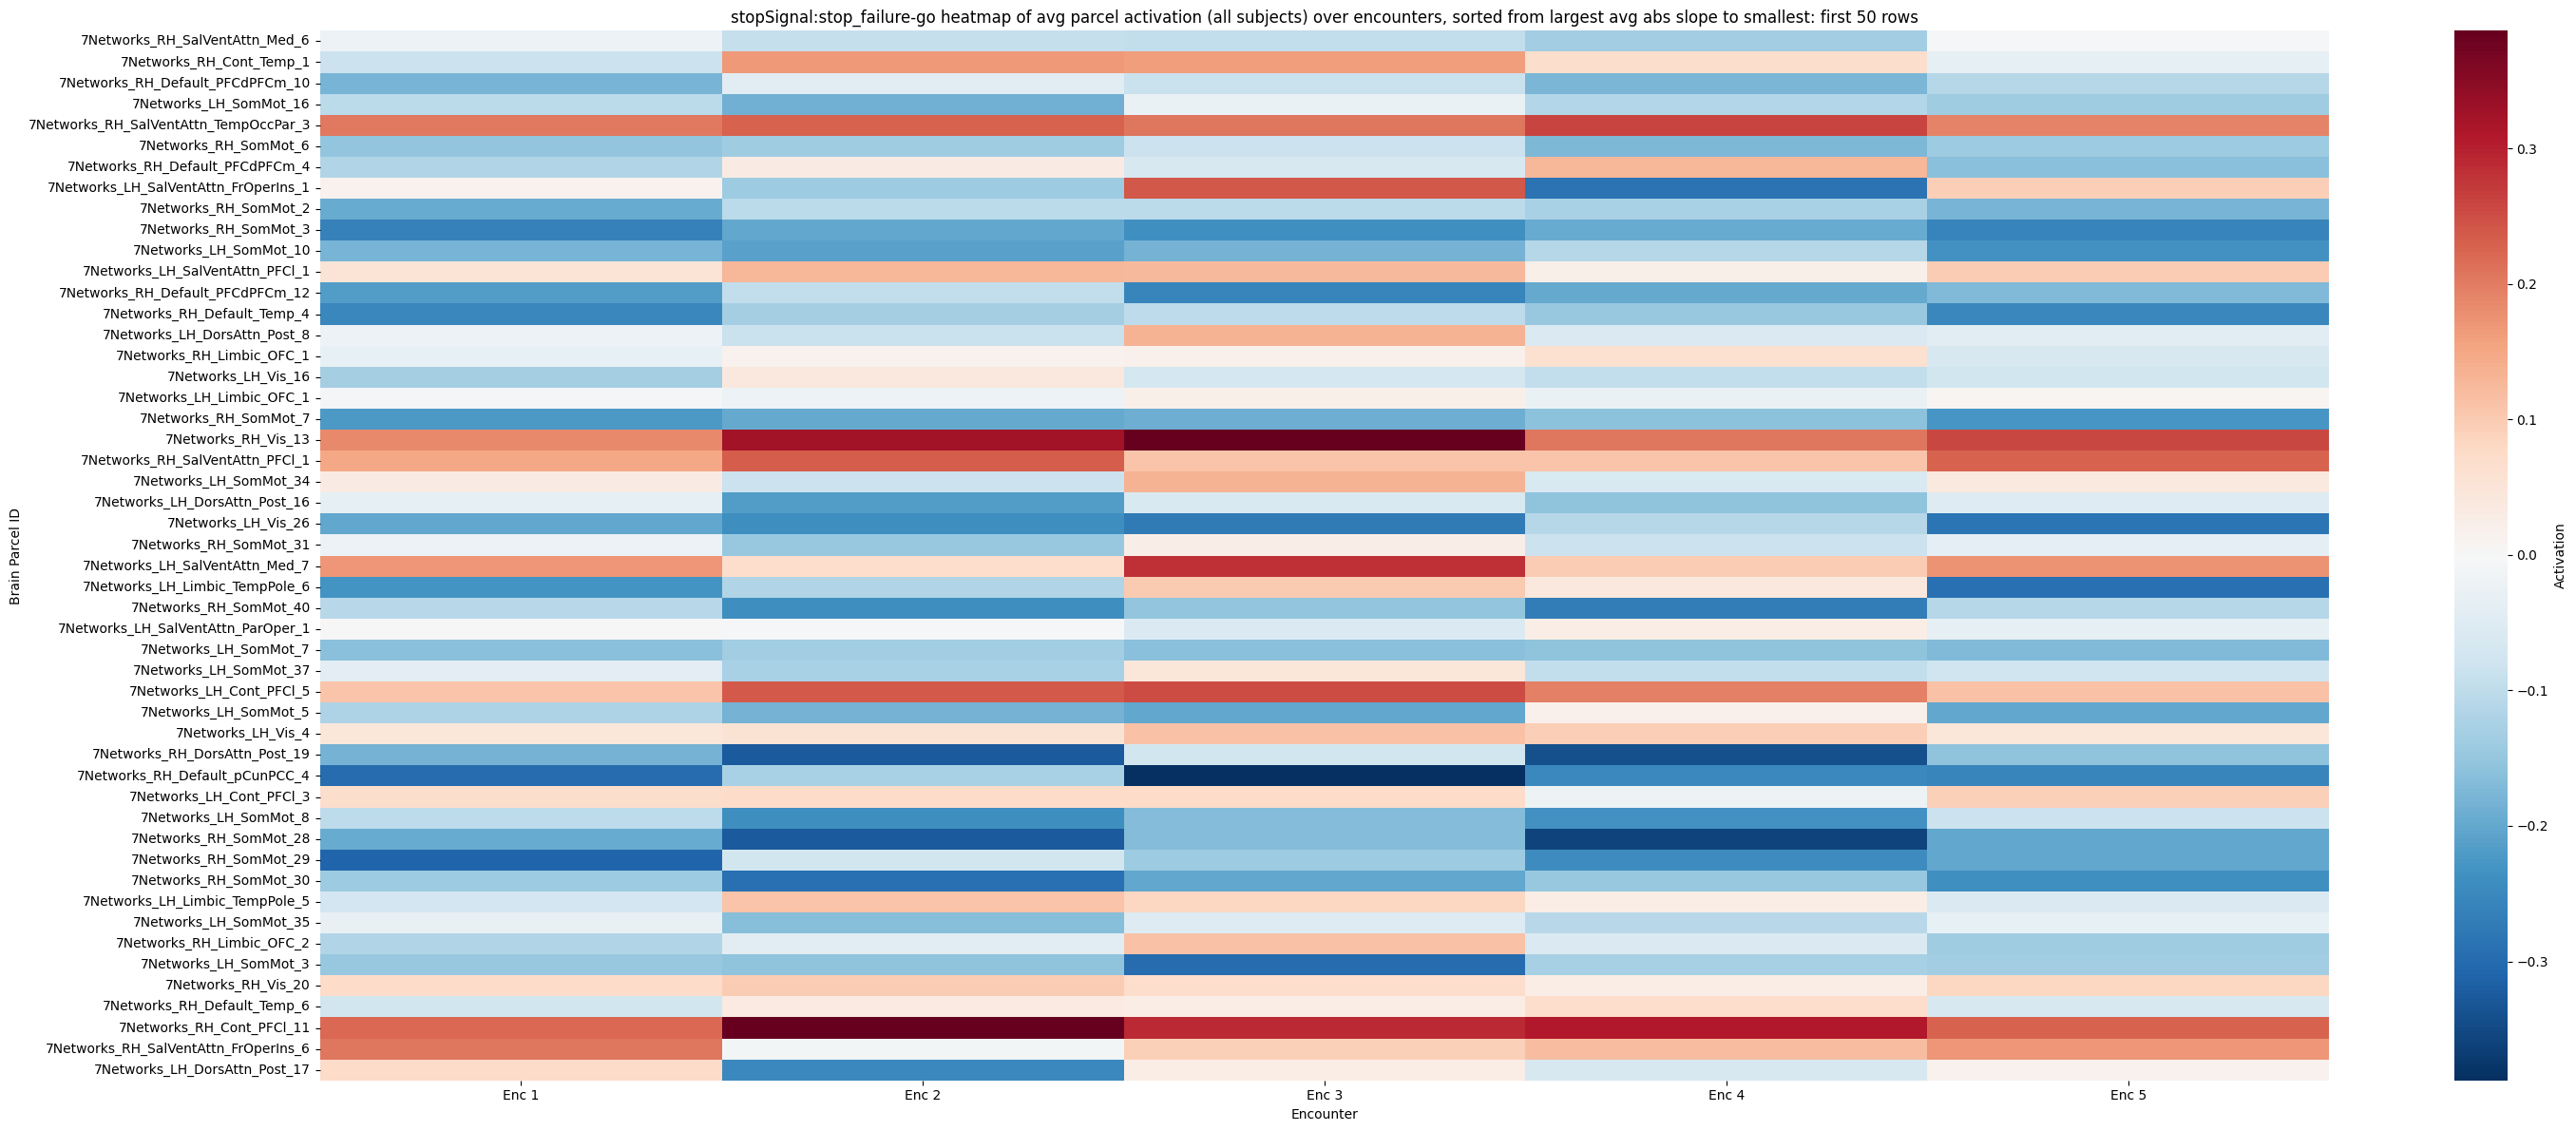

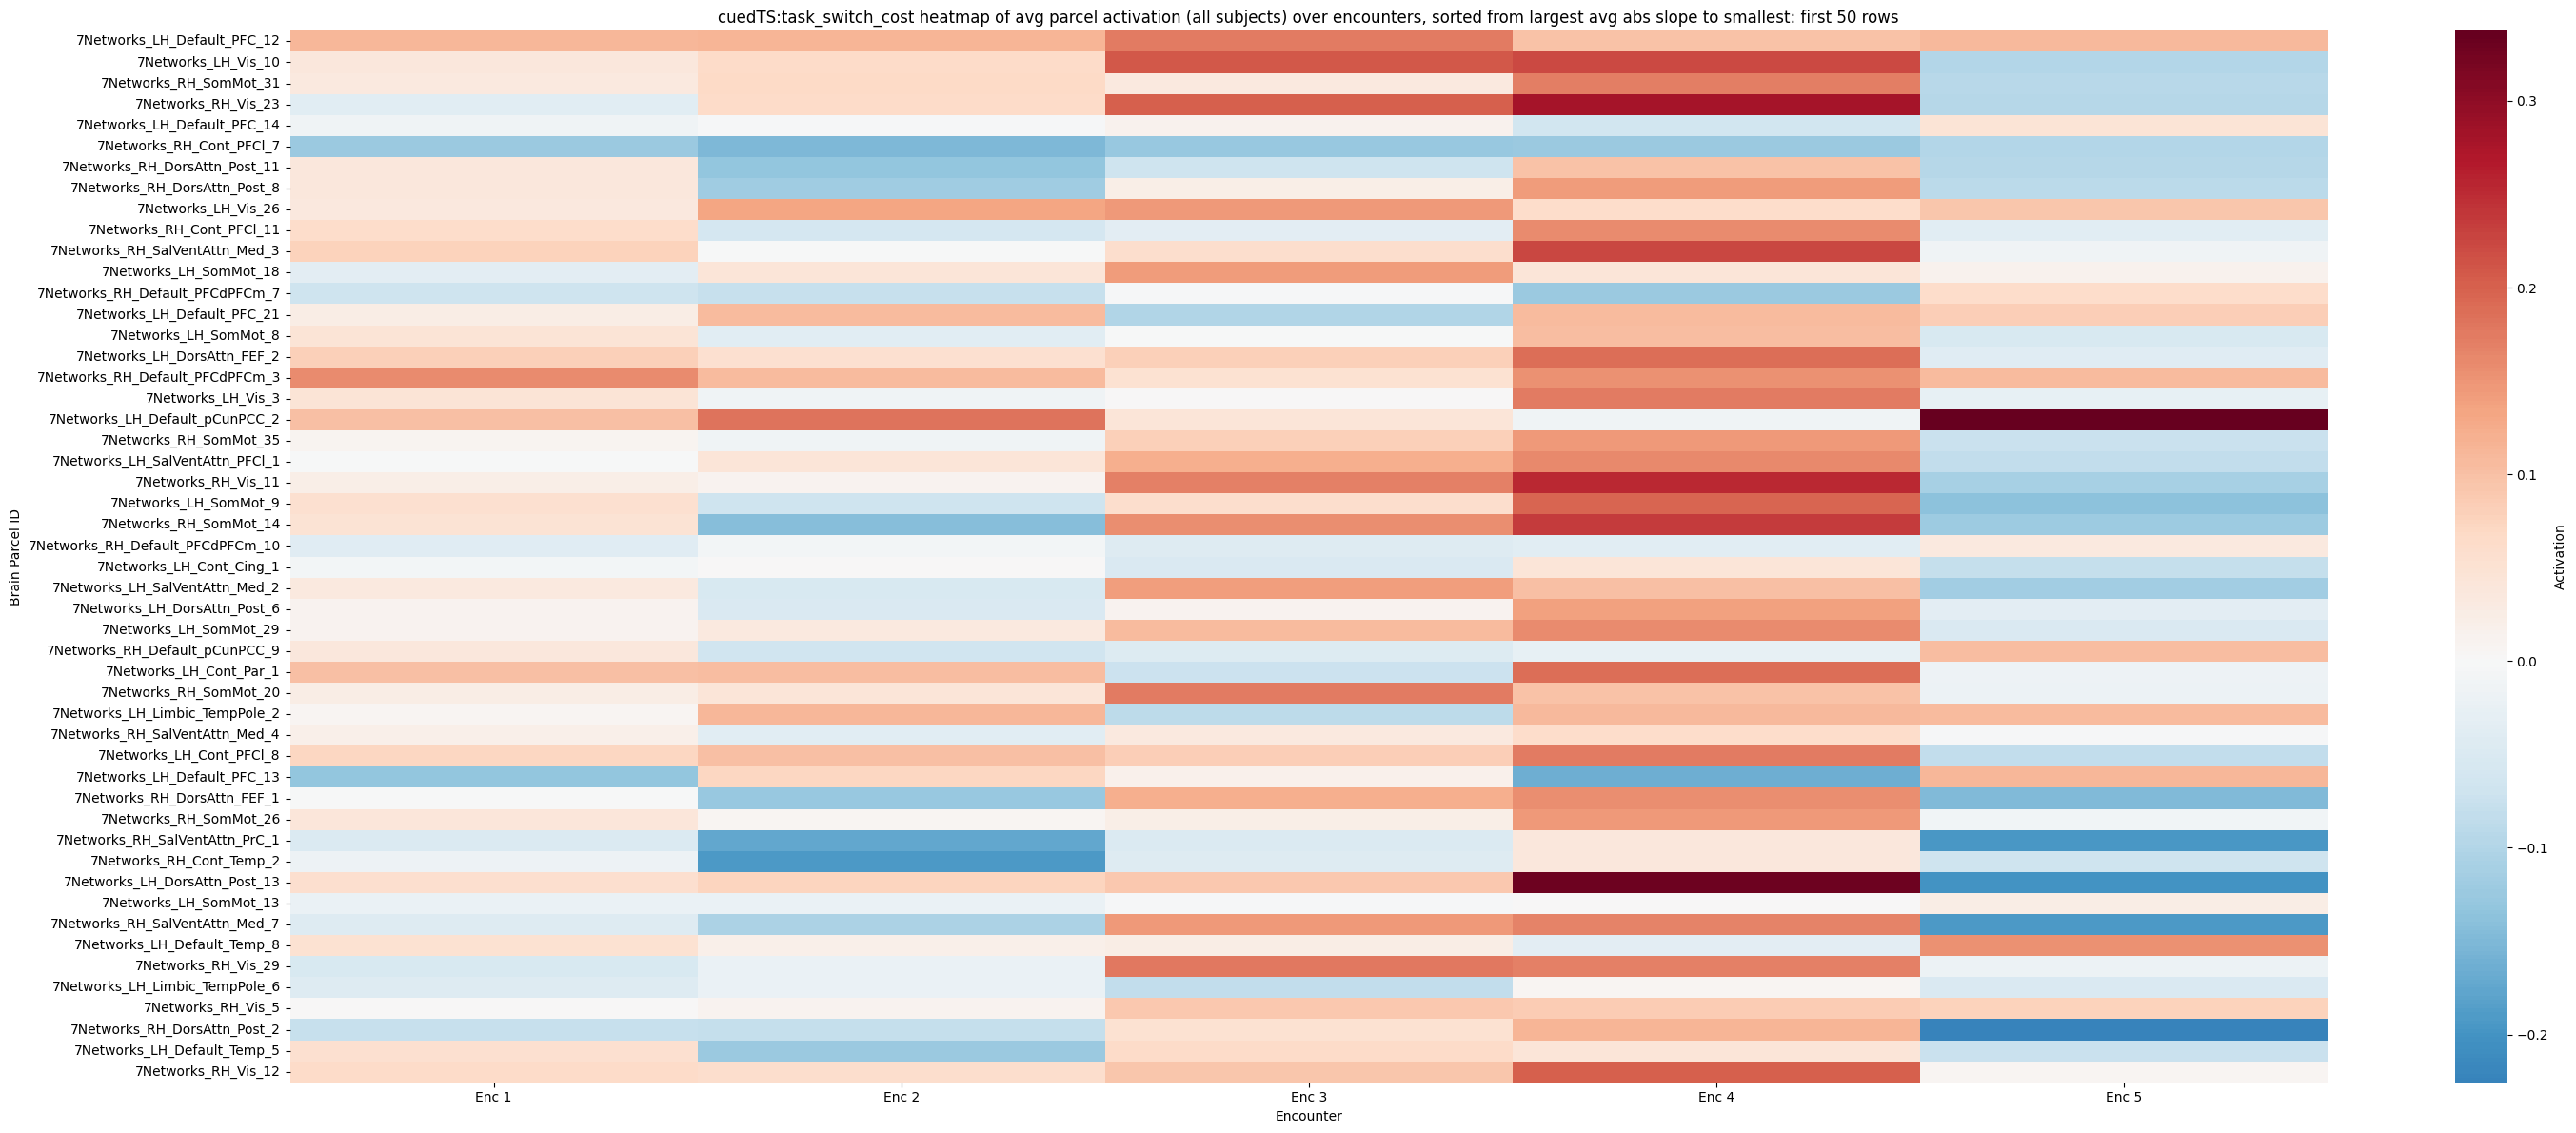

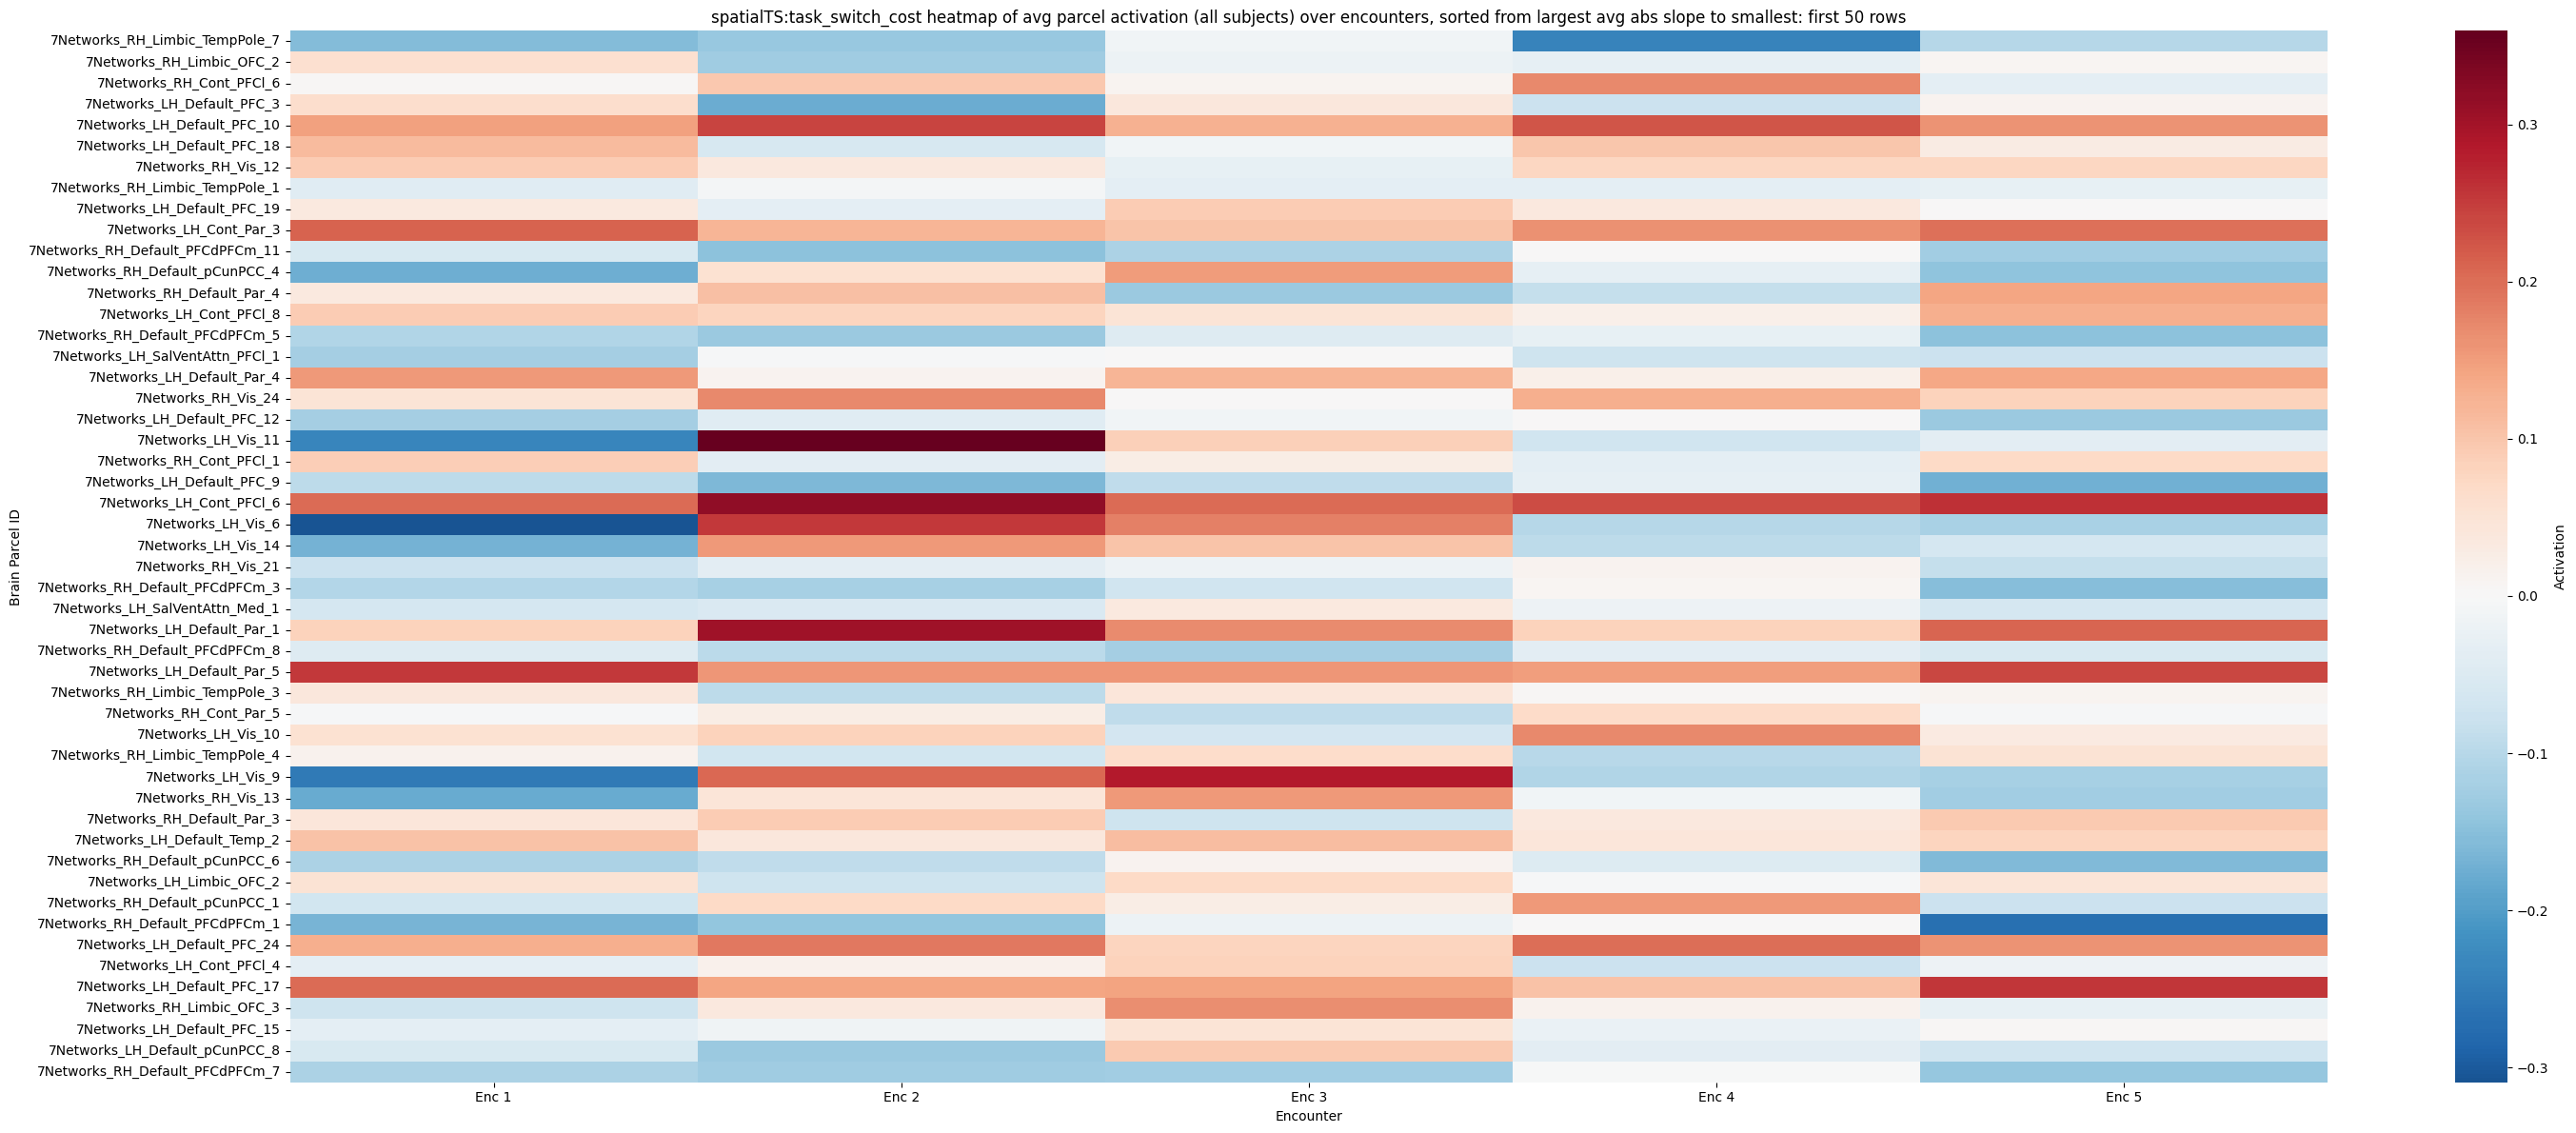

In [26]:
for task in requested_task_contrasts:
    contrast = requested_task_contrasts[task][0]
    title = f"{task}:{contrast} heatmap of avg parcel activation (all subjects) over encounters, sorted from largest avg abs slope to smallest"

    create_parcel_practice_heatmap(avg_parcel_traj_results[task][contrast],title,indiv_data=False,n_rows=50)

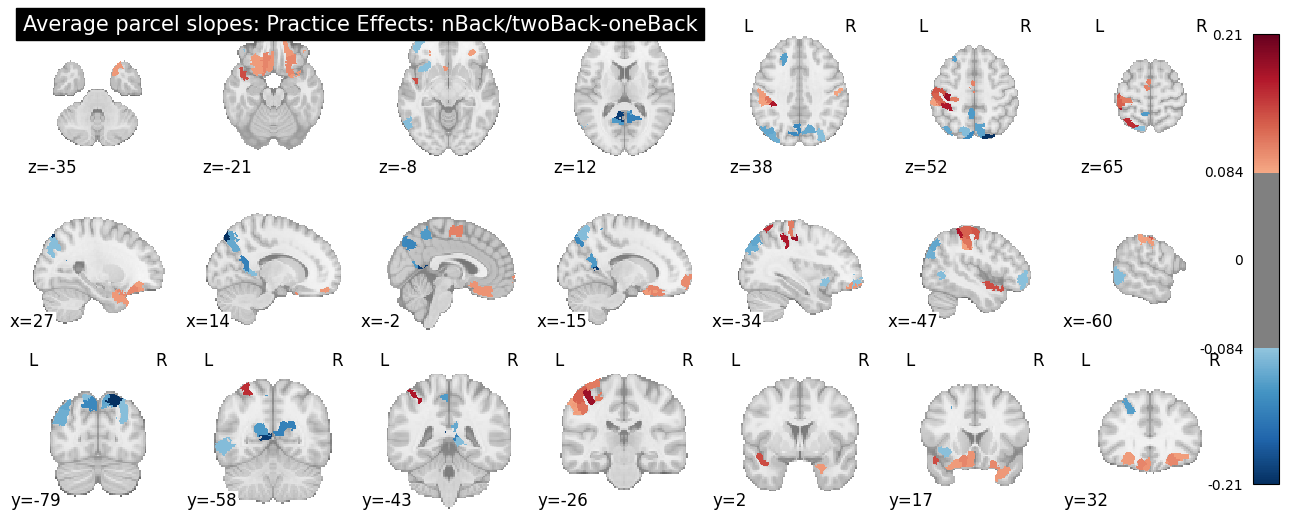


Top 50 Practice Effects for nBack/twoBack-oneBack
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_DorsAttn_Post_7                       -0.2134    Decline     
2     7Networks_LH_Default_pCunPCC_1                     -0.2019    Decline     
3     7Networks_LH_SomMot_22                             0.1818     Improvement 
4     7Networks_LH_DorsAttn_Post_11                      0.1726     Improvement 
5     7Networks_LH_DorsAttn_Post_14                      0.1569     Improvement 
6     7Networks_RH_Default_pCunPCC_1                     -0.1442    Decline     
7     7Networks_LH_Default_pCunPCC_10                    -0.1397    Decline     
8     7Networks_LH_SalVentAttn_FrOperIns_1               0.1390     Improvement 
9     7Networks_LH_Cont_pCun_1                           -0.1376    Decline     
10    7Networks_LH_SomMot_20                             0

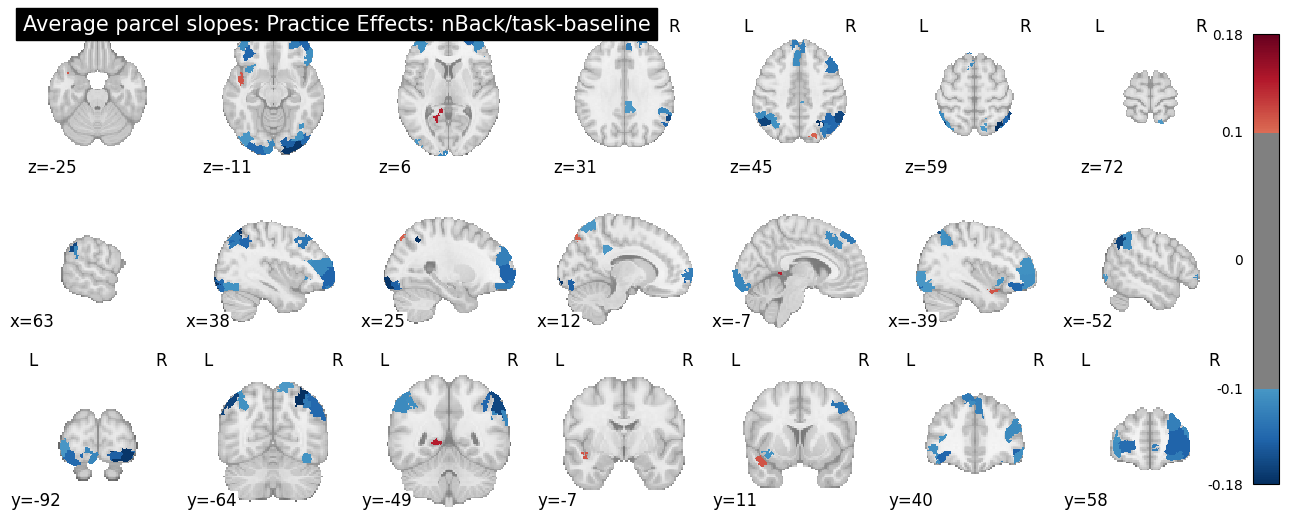


Top 50 Practice Effects for nBack/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_DorsAttn_Post_10                      -0.1786    Decline     
2     7Networks_RH_Vis_13                                -0.1742    Decline     
3     7Networks_LH_Default_Par_7                         -0.1649    Decline     
4     7Networks_RH_Cont_Par_1                            -0.1623    Decline     
5     7Networks_RH_Vis_8                                 -0.1454    Decline     
6     7Networks_RH_Cont_PFCl_3                           -0.1436    Decline     
7     7Networks_RH_Cont_PFCl_2                           -0.1424    Decline     
8     7Networks_RH_Cont_Par_6                            -0.1419    Decline     
9     7Networks_LH_Default_PFC_2                         -0.1414    Decline     
10    7Networks_LH_Vis_20                                0.1

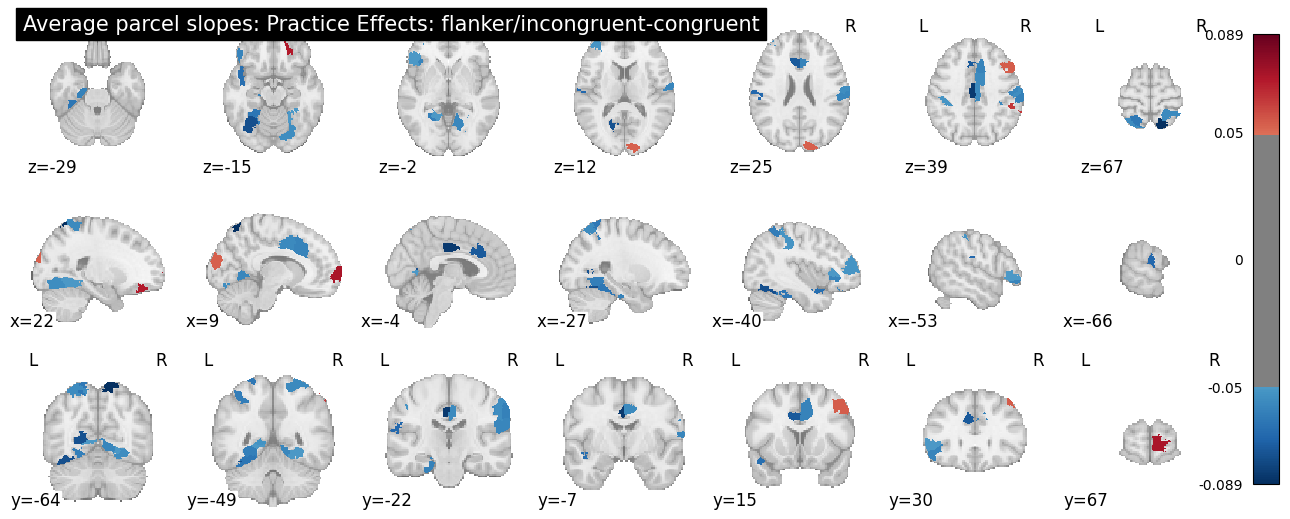


Top 50 Practice Effects for flanker/incongruent-congruent
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_DorsAttn_Post_18                      -0.0892    Decline     
2     7Networks_LH_Default_pCunPCC_9                     -0.0851    Decline     
3     7Networks_LH_Vis_3                                 -0.0782    Decline     
4     7Networks_LH_Vis_22                                -0.0778    Decline     
5     7Networks_LH_SalVentAttn_Med_1                     -0.0751    Decline     
6     7Networks_RH_Default_PFCdPFCm_2                    0.0730     Improvement 
7     7Networks_RH_Limbic_OFC_4                          0.0706     Improvement 
8     7Networks_LH_SomMot_11                             -0.0701    Decline     
9     7Networks_LH_SalVentAttn_FrOperIns_1               -0.0669    Decline     
10    7Networks_LH_Vis_1                          

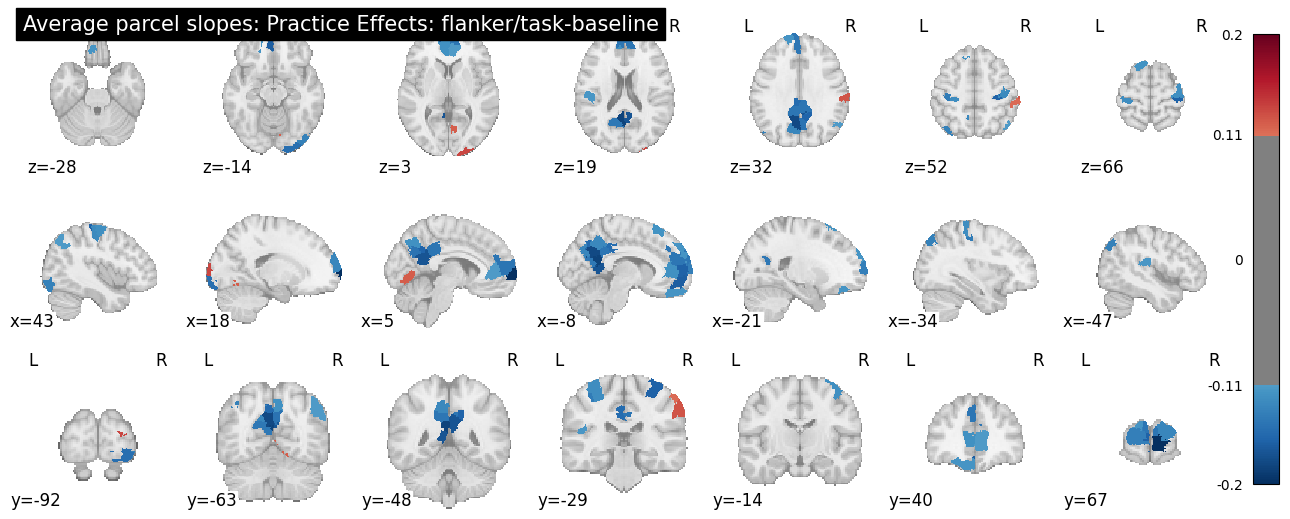


Top 50 Practice Effects for flanker/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_Default_PFCdPFCm_2                    -0.1970    Decline     
2     7Networks_LH_Default_pCunPCC_3                     -0.1826    Decline     
3     7Networks_LH_Default_pCunPCC_6                     -0.1784    Decline     
4     7Networks_LH_Default_pCunPCC_1                     -0.1698    Decline     
5     7Networks_RH_Default_pCunPCC_4                     -0.1695    Decline     
6     7Networks_LH_Default_PFC_3                         -0.1619    Decline     
7     7Networks_LH_Default_PFC_8                         -0.1595    Decline     
8     7Networks_RH_SomMot_29                             -0.1588    Decline     
9     7Networks_RH_Default_pCunPCC_8                     -0.1581    Decline     
10    7Networks_LH_Default_pCunPCC_10                    -

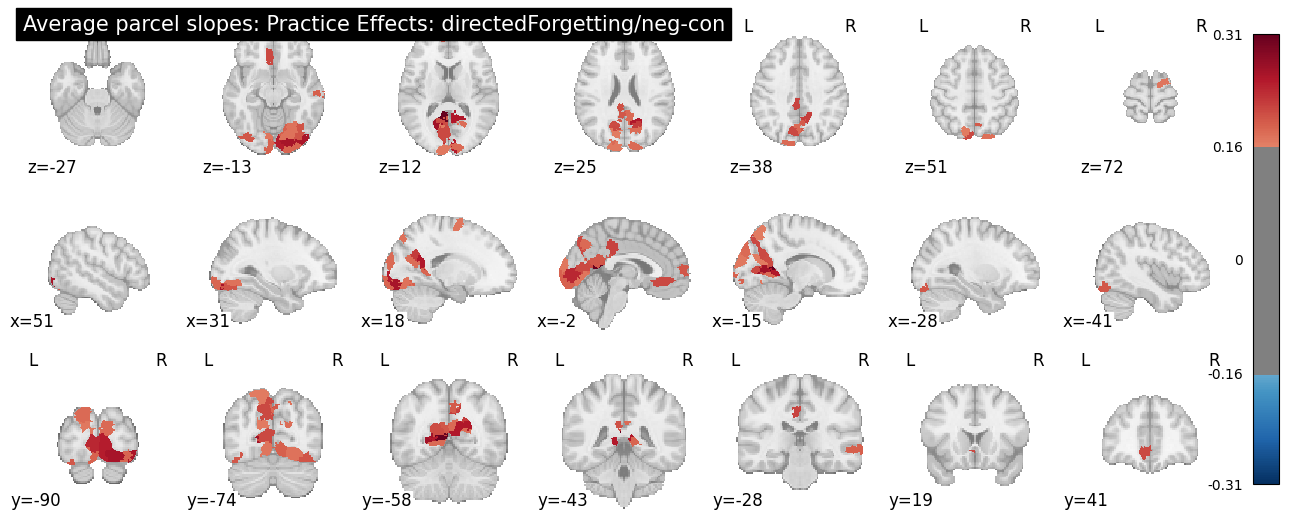


Top 50 Practice Effects for directedForgetting/neg-con
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Default_pCunPCC_1                     0.3112     Improvement 
2     7Networks_LH_Vis_22                                0.2601     Improvement 
3     7Networks_RH_Vis_8                                 0.2567     Improvement 
4     7Networks_RH_Vis_10                                0.2537     Improvement 
5     7Networks_RH_Default_pCunPCC_1                     0.2501     Improvement 
6     7Networks_LH_Vis_20                                0.2463     Improvement 
7     7Networks_RH_Vis_15                                0.2448     Improvement 
8     7Networks_LH_Vis_18                                0.2345     Improvement 
9     7Networks_RH_Default_pCunPCC_3                     0.2183     Improvement 
10    7Networks_RH_Default_pCunPCC_8                 

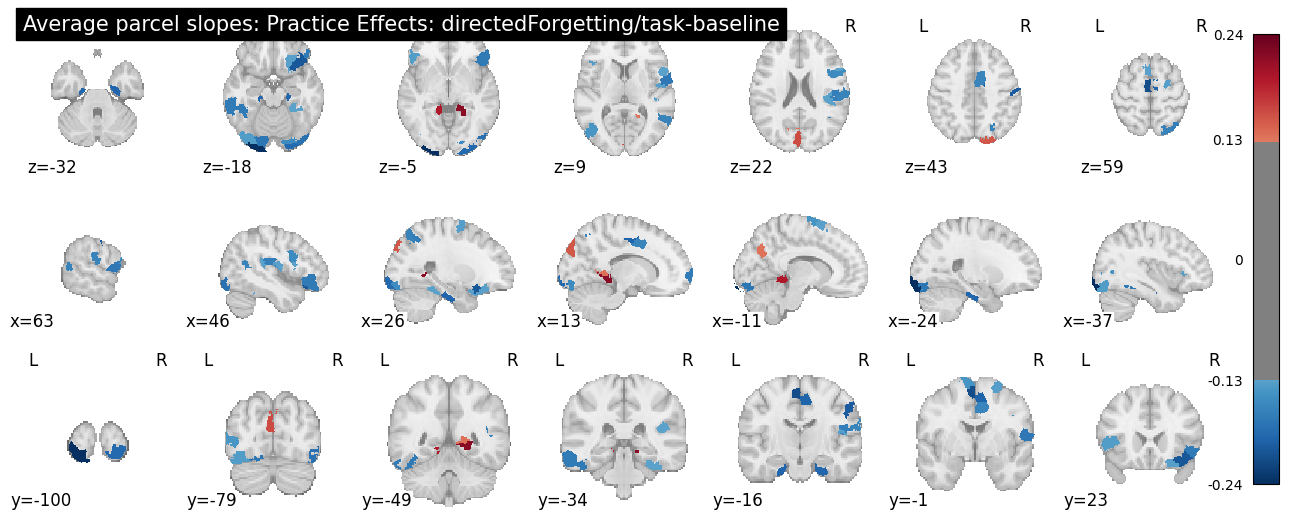


Top 50 Practice Effects for directedForgetting/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Vis_12                                -0.2356    Decline     
2     7Networks_RH_Vis_14                                0.2125     Improvement 
3     7Networks_LH_SomMot_25                             -0.2082    Decline     
4     7Networks_RH_Default_PFCv_1                        -0.2000    Decline     
5     7Networks_RH_SomMot_19                             -0.1958    Decline     
6     7Networks_LH_Vis_13                                0.1891     Improvement 
7     7Networks_RH_SomMot_24                             -0.1890    Decline     
8     7Networks_RH_Limbic_TempPole_7                     -0.1876    Decline     
9     7Networks_LH_Limbic_TempPole_8                     -0.1865    Decline     
10    7Networks_RH_Vis_13                      

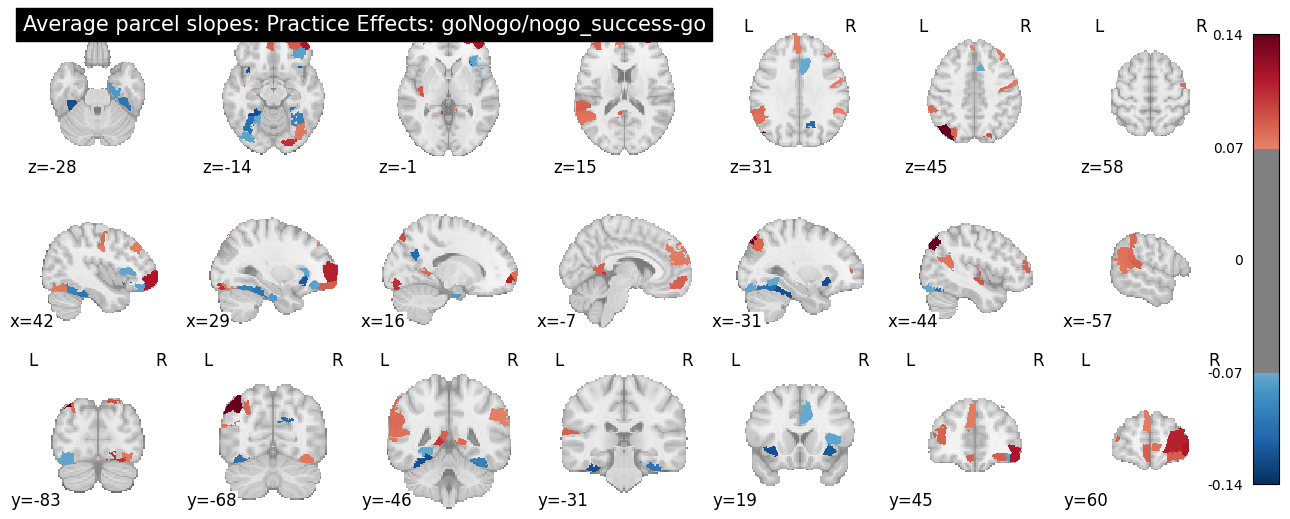


Top 50 Practice Effects for goNogo/nogo_success-go
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Default_Par_6                         0.1409     Improvement 
2     7Networks_LH_Vis_1                                 -0.1240    Decline     
3     7Networks_LH_Cont_PFCv_1                           -0.1239    Decline     
4     7Networks_RH_Cont_PFCv_1                           -0.1187    Decline     
5     7Networks_RH_Cont_PFCl_2                           0.1144     Improvement 
6     7Networks_RH_Default_pCunPCC_3                     -0.1098    Decline     
7     7Networks_RH_Cont_PFCl_3                           0.1081     Improvement 
8     7Networks_LH_Vis_3                                 -0.1054    Decline     
9     7Networks_RH_Vis_8                                 0.1033     Improvement 
10    7Networks_RH_Vis_1                                 

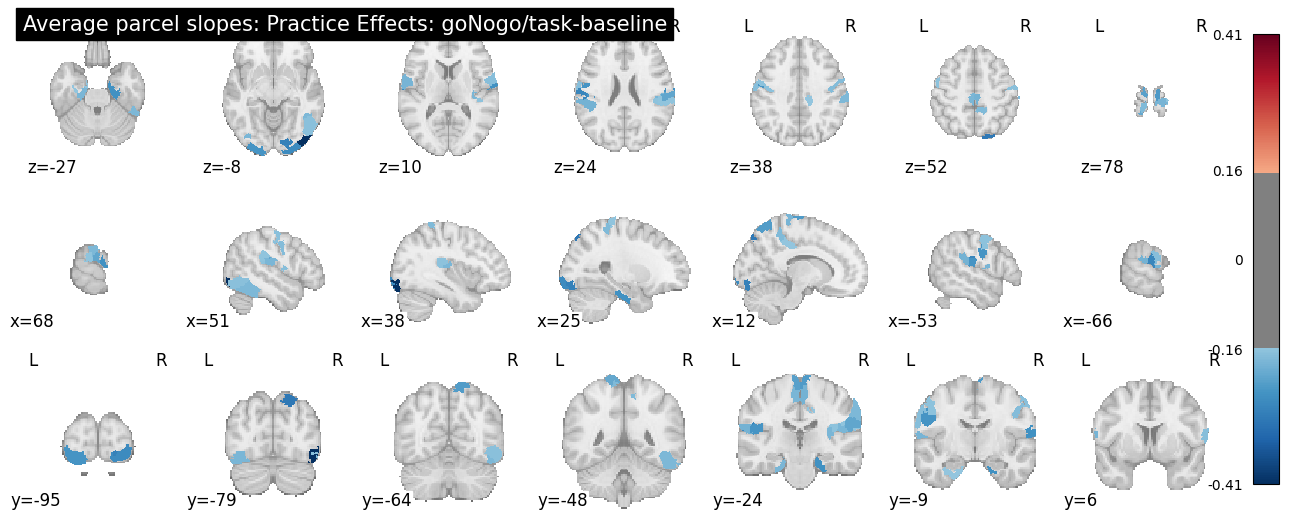


Top 50 Practice Effects for goNogo/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_RH_Vis_10                                -0.4094    Decline     
2     7Networks_RH_DorsAttn_Post_7                       -0.2936    Decline     
3     7Networks_RH_Vis_8                                 -0.2771    Decline     
4     7Networks_LH_SomMot_11                             -0.2655    Decline     
5     7Networks_RH_Vis_13                                -0.2585    Decline     
6     7Networks_RH_SomMot_14                             -0.2474    Decline     
7     7Networks_RH_Limbic_TempPole_7                     -0.2470    Decline     
8     7Networks_LH_SomMot_10                             -0.2414    Decline     
9     7Networks_LH_Vis_12                                -0.2411    Decline     
10    7Networks_LH_SomMot_14                             -0

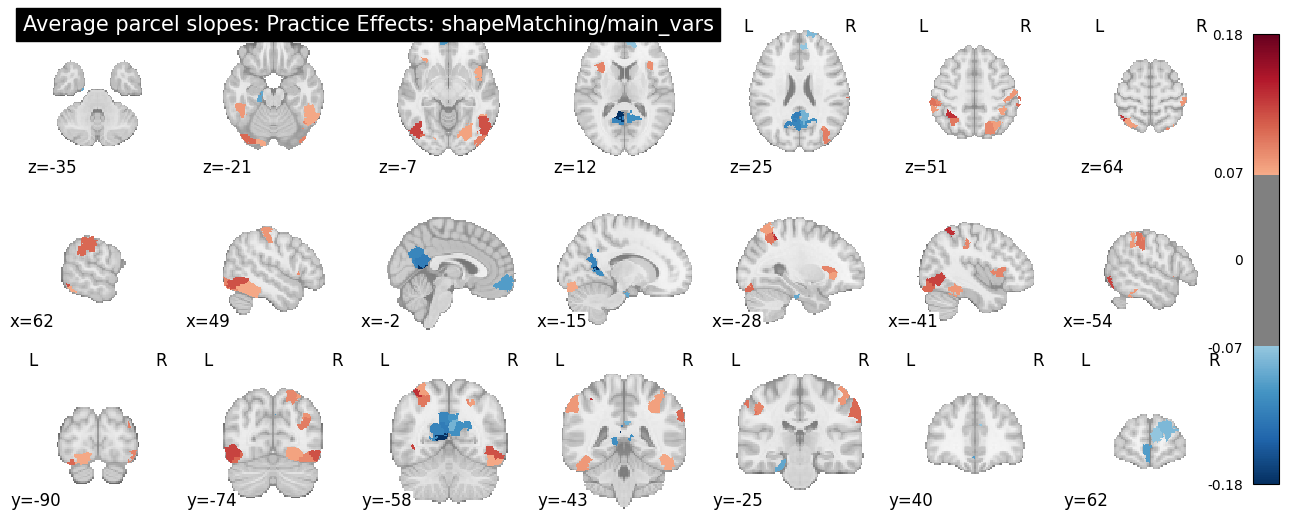


Top 50 Practice Effects for shapeMatching/main_vars
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Default_pCunPCC_1                     -0.1821    Decline     
2     7Networks_LH_DorsAttn_Post_12                      0.1324     Improvement 
3     7Networks_LH_Default_pCunPCC_3                     -0.1269    Decline     
4     7Networks_LH_Vis_8                                 0.1234     Improvement 
5     7Networks_LH_Default_pCunPCC_2                     -0.1206    Decline     
6     7Networks_LH_Default_pCunPCC_6                     -0.1191    Decline     
7     7Networks_RH_Vis_9                                 0.1153     Improvement 
8     7Networks_LH_Vis_20                                -0.1130    Decline     
9     7Networks_RH_Default_pCunPCC_1                     -0.1122    Decline     
10    7Networks_RH_Default_pCunPCC_5                    

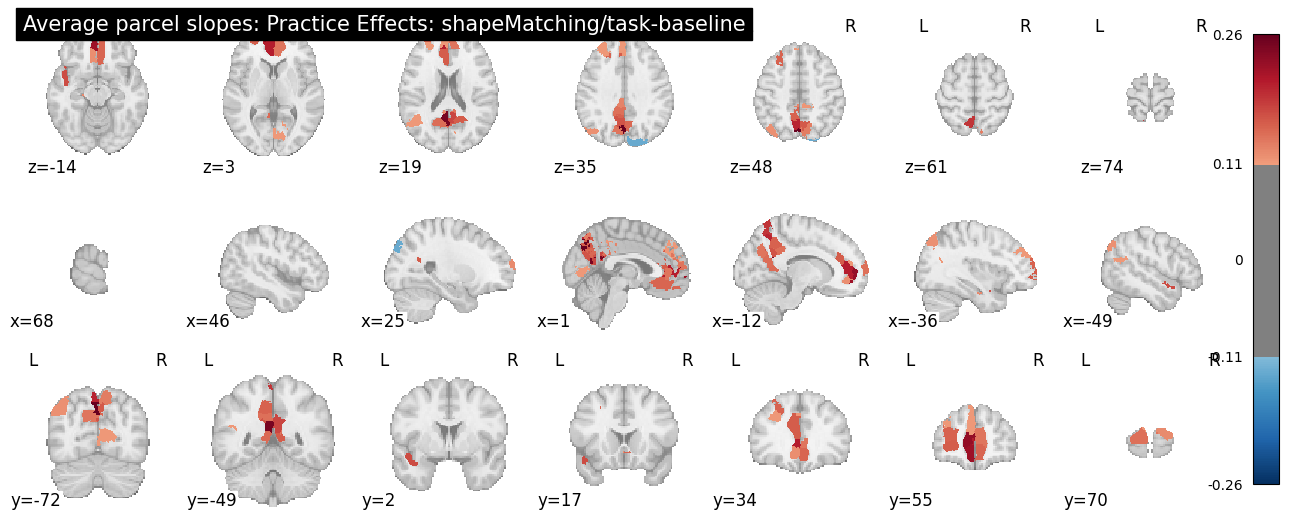


Top 50 Practice Effects for shapeMatching/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Default_pCunPCC_10                    0.2618     Improvement 
2     7Networks_LH_Default_pCunPCC_3                     0.2482     Improvement 
3     7Networks_LH_Default_PFC_8                         0.2303     Improvement 
4     7Networks_LH_Default_PFC_3                         0.2214     Improvement 
5     7Networks_LH_Default_PFC_9                         0.2055     Improvement 
6     7Networks_LH_Cont_pCun_2                           0.2003     Improvement 
7     7Networks_LH_DorsAttn_Post_15                      0.1880     Improvement 
8     7Networks_RH_Default_pCunPCC_4                     0.1740     Improvement 
9     7Networks_LH_SalVentAttn_FrOperIns_1               0.1701     Improvement 
10    7Networks_LH_Default_pCunPCC_6                

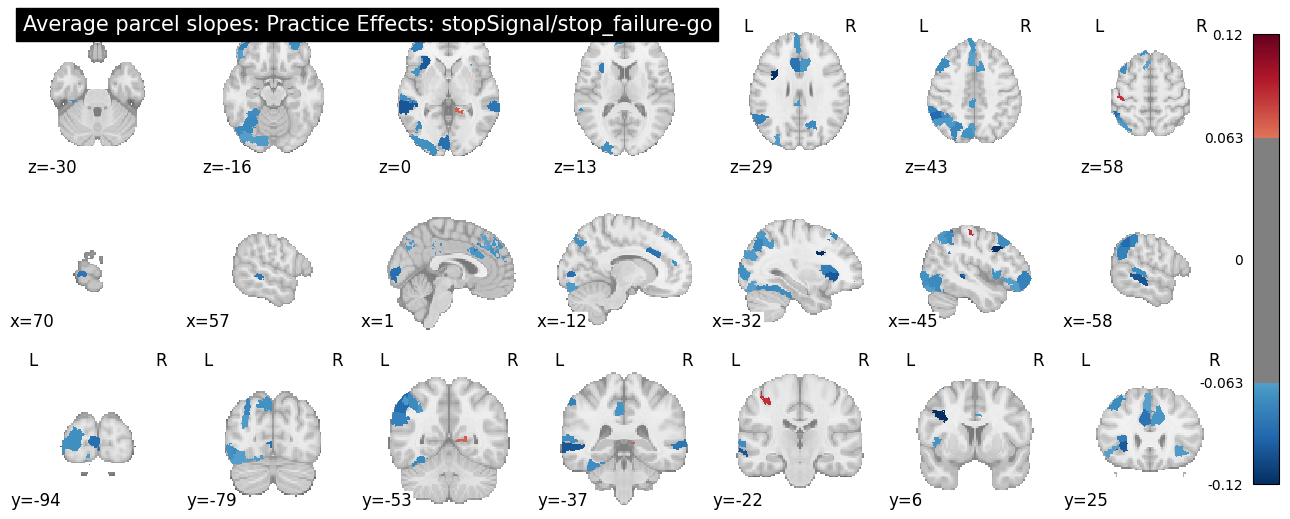


Top 50 Practice Effects for stopSignal/stop_failure-go
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Cont_PFCl_7                           -0.1161    Decline     
2     7Networks_LH_Default_Temp_6                        -0.0993    Decline     
3     7Networks_LH_SalVentAttn_FrOperIns_3               -0.0978    Decline     
4     7Networks_LH_Cont_Par_3                            -0.0889    Decline     
5     7Networks_LH_Vis_18                                -0.0879    Decline     
6     7Networks_LH_SalVentAttn_Med_1                     -0.0860    Decline     
7     7Networks_LH_SomMot_22                             0.0848     Improvement 
8     7Networks_RH_Default_Temp_7                        -0.0841    Decline     
9     7Networks_LH_SalVentAttn_FrOperIns_5               -0.0799    Decline     
10    7Networks_LH_Cont_Par_2                        

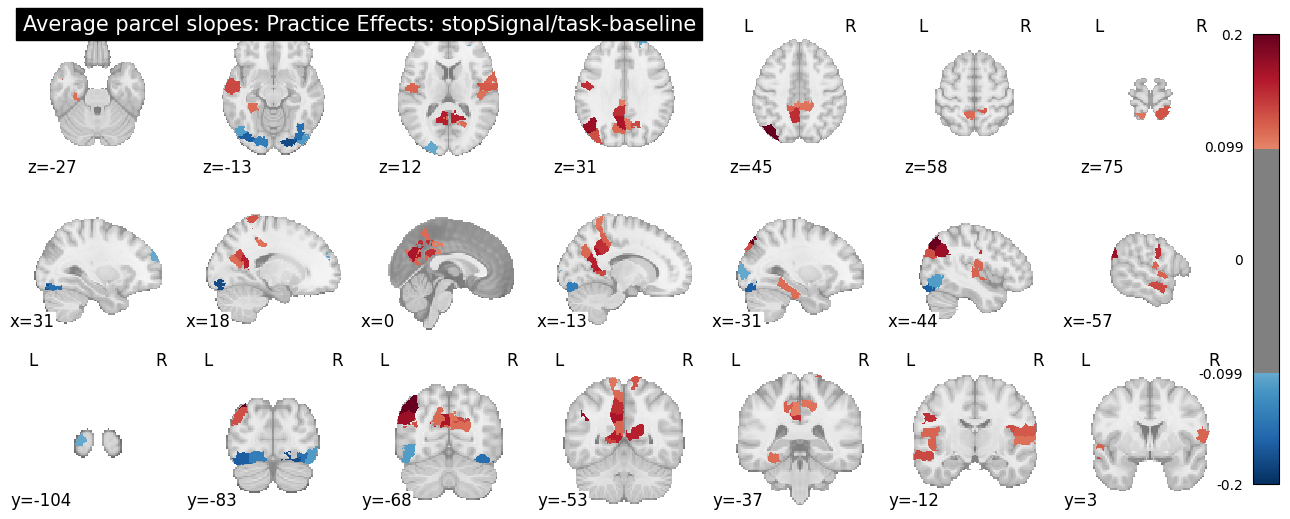


Top 50 Practice Effects for stopSignal/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Default_Par_6                         0.1950     Improvement 
2     7Networks_RH_Vis_8                                 -0.1747    Decline     
3     7Networks_LH_Default_Par_4                         0.1663     Improvement 
4     7Networks_LH_Vis_6                                 -0.1608    Decline     
5     7Networks_LH_Default_pCunPCC_6                     0.1587     Improvement 
6     7Networks_LH_Default_pCunPCC_1                     0.1531     Improvement 
7     7Networks_LH_Default_pCunPCC_2                     0.1522     Improvement 
8     7Networks_RH_Default_pCunPCC_1                     0.1517     Improvement 
9     7Networks_RH_Vis_4                                 -0.1472    Decline     
10    7Networks_LH_Default_pCunPCC_11                  

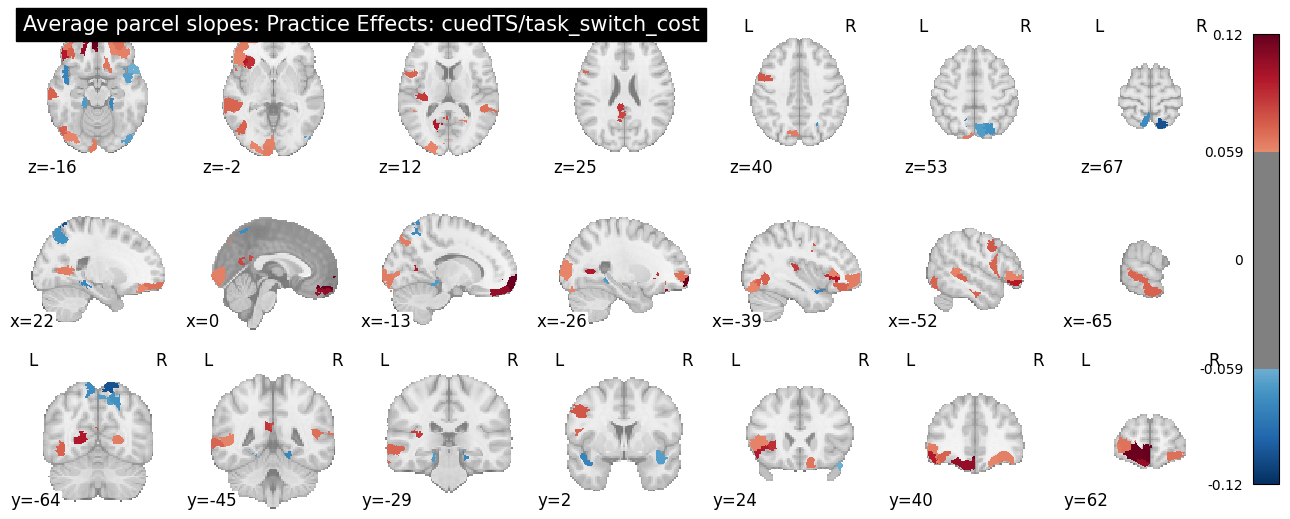


Top 50 Practice Effects for cuedTS/task_switch_cost
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Default_PFC_3                         0.1230     Improvement 
2     7Networks_LH_Limbic_OFC_5                          0.1202     Improvement 
3     7Networks_LH_Limbic_OFC_3                          0.1085     Improvement 
4     7Networks_RH_DorsAttn_Post_18                      -0.1073    Decline     
5     7Networks_LH_Vis_22                                0.0987     Improvement 
6     7Networks_LH_Default_PFC_5                         0.0971     Improvement 
7     7Networks_LH_SalVentAttn_FrOperIns_3               0.0898     Improvement 
8     7Networks_LH_Default_pCunPCC_4                     0.0876     Improvement 
9     7Networks_LH_SomMot_3                              0.0857     Improvement 
10    7Networks_LH_Default_pCunPCC_3                    

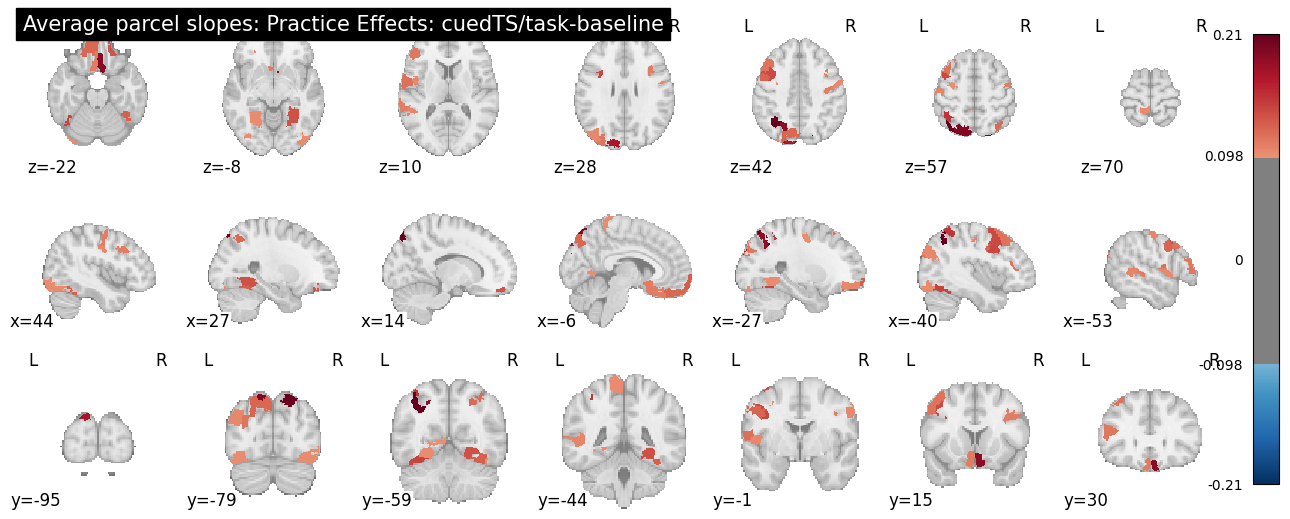


Top 50 Practice Effects for cuedTS/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Cont_Par_4                            0.2110     Improvement 
2     7Networks_RH_DorsAttn_Post_7                       0.2072     Improvement 
3     7Networks_LH_DorsAttn_Post_13                      0.1961     Improvement 
4     7Networks_RH_Limbic_OFC_5                          0.1908     Improvement 
5     7Networks_LH_DorsAttn_Post_7                       0.1864     Improvement 
6     7Networks_LH_Vis_29                                0.1725     Improvement 
7     7Networks_LH_DorsAttn_Post_12                      0.1515     Improvement 
8     7Networks_LH_Vis_3                                 0.1419     Improvement 
9     7Networks_LH_Cont_PFCl_7                           0.1417     Improvement 
10    7Networks_LH_Default_PFC_20                        0.

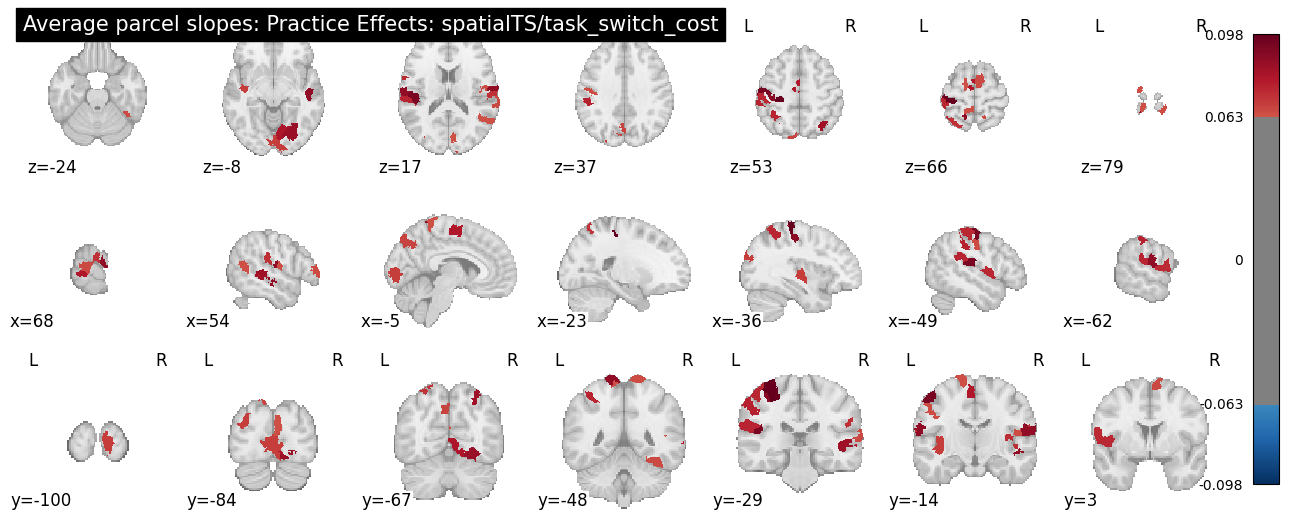


Top 50 Practice Effects for spatialTS/task_switch_cost
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_SomMot_28                             0.0979     Improvement 
2     7Networks_LH_SomMot_20                             0.0929     Improvement 
3     7Networks_LH_SomMot_10                             0.0919     Improvement 
4     7Networks_LH_SomMot_22                             0.0883     Improvement 
5     7Networks_LH_DorsAttn_Post_17                      0.0869     Improvement 
6     7Networks_RH_Default_Temp_6                        0.0867     Improvement 
7     7Networks_RH_SomMot_14                             0.0866     Improvement 
8     7Networks_LH_SomMot_11                             0.0865     Improvement 
9     7Networks_RH_Vis_6                                 0.0847     Improvement 
10    7Networks_RH_Default_Temp_8                    

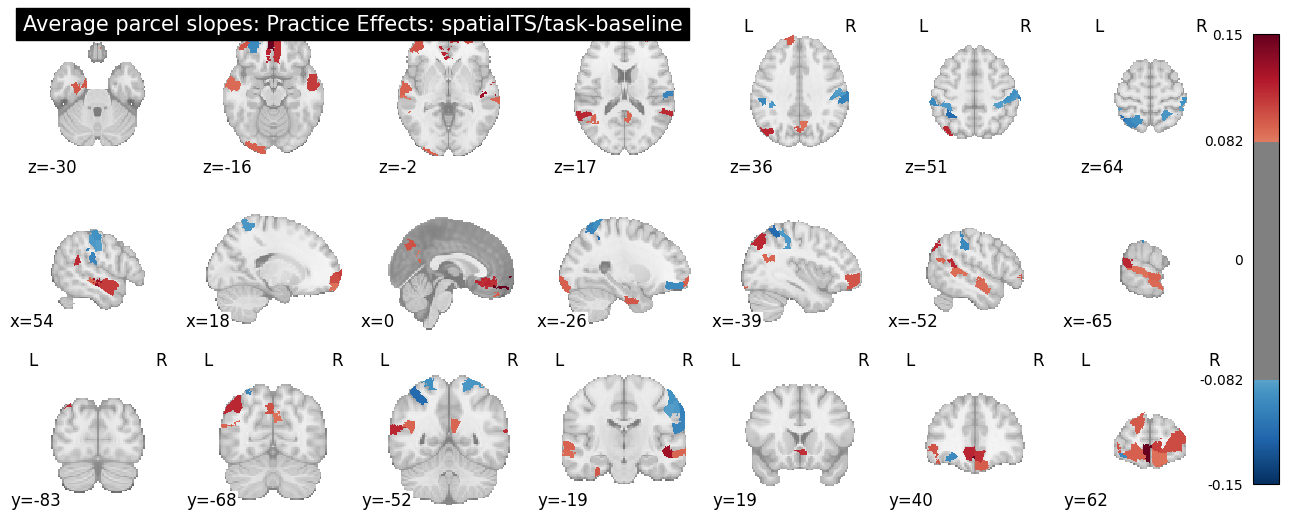


Top 50 Practice Effects for spatialTS/task-baseline
Rank  Region                                             Slope      Direction   
--------------------------------------------------------------------------------
1     7Networks_LH_Default_PFC_3                         0.1540     Improvement 
2     7Networks_RH_Default_Temp_6                        0.1304     Improvement 
3     7Networks_LH_DorsAttn_Post_12                      -0.1202    Decline     
4     7Networks_LH_Default_PFC_4                         0.1178     Improvement 
5     7Networks_LH_Default_Par_1                         0.1166     Improvement 
6     7Networks_LH_Default_Par_6                         0.1158     Improvement 
7     7Networks_RH_Default_Par_1                         0.1145     Improvement 
8     7Networks_RH_Default_PFCdPFCm_1                    0.1124     Improvement 
9     7Networks_RH_Default_Temp_4                        0.1082     Improvement 
10    7Networks_RH_Default_PFCdPFCm_2                   

In [34]:
# Plot all contrasts 
for task in avg_parcel_traj_results.keys():
    for contrast in avg_parcel_traj_results[task].keys():
        if len(avg_parcel_traj_results[task][contrast]) > 0: 
            plot_slopes_on_brain(avg_parcel_traj_results, task, contrast)

In [ ]:
# get the average trajectory and fit a new linear model to it to see how that differs from the averaged slope maps (this might get severaly impacted by one or two subjects though)

